In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd
import scenario_generation as sg



# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif



from typing import Iterable
from pathlib import Path

#tests
from scipy.stats import kstest, ks_2samp



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

In [2]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [3]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']
state = 'New York'
if 'State' in feature_names_base:
    feature_names_base.remove('State')


test_dataframes = {}
train_dataframes = {}

for initial_state in ['A', 'D', 'U']:
    end_state = 'all'
    # for end_state in ['A', 'D', 'U', 'all']:
    # if initial_state == end_state:
    #     continue
    print(f"Preprocessing data for initial state '{initial_state}' and final state '{end_state}'...")
    train_val_df, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                            weather_data_path=weather_data_file,
                                                                                            power_load_data_path=power_load_file,
                                                                                            feature_names=feature_names_base,
                                                                                            cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                            state_filter = state,
                                                                                            state_one_hot=False,
                                                                                            initial_MC_state_filter=initial_state,
                                                                                            final_MC_state_target = end_state,
                                                                                            technology_filter=technologies,
                                                                                            technology_one_hot=True,
                                                                                            test_periods=test_periods,
                                                                                            dropNA = True,
                                                                                            feature_na_drop_threshold = 0.2,
                                                                                            )
    # test_dataframes[f"{initial_state}-{end_state}"] = test_df
    test_dataframes[initial_state] = test_df
    train_dataframes[initial_state] = train_val_df
    break


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']
Preprocessing data for initial state 'A' and final state 'all'...
Standardized features (31): ['Precip_1d', 'Tmin', 'CDD', 'CDD3d', 'Heat_index', 'Tmax', 'Extreme_cold', '24h_min_load', 'Hourly_load_change', 'Temperature', 'Sea_level_pressure', 'Load', 'Wet_bulb_temperature', 'Precipitation', 'Tmean', 'HDD', '24h_max_load', 'FDD3d', 'Station_level_pressure', 'Dew_point_temperature', 'Relative_humidity', '1d_load_sum', 'Wind_speed', 'FDD', 'Snow_d

In [7]:
train_val_df.columns

Index(['Precip_1d', 'Tmin', 'State', 'CDD', 'CDD3d', 'Heat_index', 'Tmax',
       'DayOfWeek_sin', 'Extreme_cold', 'Month_cos', '24h_min_load',
       'Hourly_load_change', 'Temperature', 'Sea_level_pressure',
       'Data_weight', 'Load', 'Wet_bulb_temperature', 'Precipitation', 'Tmean',
       'HDD', 'DayOfWeek_cos', 'Heat_index_isnan', '24h_max_load', 'Month_sin',
       'Season_sin', 'FDD3d', 'Weekend', 'DayOfYear_sin',
       'Station_level_pressure', 'Dew_point_temperature', 'Holiday',
       'Relative_humidity', 'DayOfYear_cos', '1d_load_sum', 'Wind_speed',
       'FDD', 'Season_cos', 'Snow_depth', 'Final_gen_state', 'Wind_chill',
       'Extreme_heat', '2d_load_sum', 'Wind_chill_isnan',
       'Pressure_3hr_change', 'HDD3d', 'Datetime_UTC', 'Precip_3d'],
      dtype='object')

In [5]:
train_val_df['data_weight']

KeyError: 'data_weight'

# Load Models

In [4]:
class composition_model:
    def __init__(self):
        self.model_to_A = None
        self.model_to_D = None
        self.model_to_U = None

        self.missing = ['A', 'D', 'U']

        self.feature_cols = None
    
    def predict(self, X):
        if len(self.missing) > 1:
            raise ValueError(f"Cannot predict, missing models for: {self.missing}")
        if 'A' in self.missing:
            D_probs = self.model_to_D.predict(X)[:, 1]
            U_probs = self.model_to_U.predict(X)[:, 1]
            A_probs = 1 - D_probs - U_probs
            combined_probs = np.vstack((A_probs, D_probs, U_probs)).T
            return combined_probs
        if 'D' in self.missing:
            A_probs = self.model_to_A.predict(X)[:, 1]
            U_probs = self.model_to_U.predict(X)[:, 1]
            D_probs = 1 - A_probs - U_probs
            combined_probs = np.vstack((A_probs, D_probs, U_probs)).T
            return combined_probs
        if 'U' in self.missing:
            A_probs = self.model_to_A.predict(X)[:, 1]
            D_probs = self.model_to_D.predict(X)[:, 1]
            U_probs = 1 - A_probs - D_probs
            combined_probs = np.vstack((A_probs, D_probs, U_probs)).T
            return combined_probs
        
    def load_A_model(self, path: str, model_type: str = 'xgboost'):
        if model_type == 'xgboost':
            model_loader = xgb.XGBClassifier()
            model = model_loader.load_model(path)
            self.model_to_A = model
        elif model_type == 'mlp':
            mlp_loader = im.MLP(verbose=False)
            model = mlp_loader.load_model(path)
            self.model_to_A = model
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        
        if self.feature_cols is None:
            self.feature_cols = model.feature_cols
        else:
            if self.feature_cols != model.feature_cols:
                raise ValueError("Feature columns of the loaded model do not match the existing feature columns.")
        self.missing.remove('A')

    def load_D_model(self, path: str, model_type: str = 'xgboost'):
        if model_type == 'xgboost':
            model_loader = xgb.XGBClassifier()
            model = model_loader.load_model(path)
            self.model_to_D = model
        elif model_type == 'mlp':
            mlp_loader = im.MLP(verbose=False)
            model = mlp_loader.load_model(path)
            self.model_to_D = model
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        
        if self.feature_cols is None:
            self.feature_cols = model.feature_cols
        else:
            if self.feature_cols != model.feature_cols:
                raise ValueError("Feature columns of the loaded model do not match the existing feature columns.")
        self.missing.remove('D')
    
    def load_U_model(self, path: str, model_type: str = 'xgboost'):
        if model_type == 'xgboost':
            model_loader = xgb.XGBClassifier()
            model = model_loader.load_model(path)
            self.model_to_U = model
        elif model_type == 'mlp':
            mlp_loader = im.MLP(verbose=False)
            model = mlp_loader.load_model(path)
            self.model_to_U = model
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        if self.feature_cols is None:
            self.feature_cols = model.feature_cols
        else:
            if self.feature_cols != model.feature_cols:
                raise ValueError("Feature columns of the loaded model do not match the existing feature columns.")
        self.missing.remove('U')

In [5]:
def CE_min(df, features):
    """Returns the probabilities that minimize the cross entropy on the test set (for comparison with model predictions)"""
    df_counts = df[features+['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts =  df_counts.groupby(features).sum('count')
    res = df.join(counts, on=features,  how='left')
    res["probability_CE_min"] = res['Data_weight'] / res['count']

    p0 = res.loc[res['Final_gen_state']==0]
    p1 = res.loc[res['Final_gen_state']==1]
    p2 = res.loc[res['Final_gen_state']==2]

    p0 = p0.groupby(['Datetime_UTC']+features).sum()
    p1 = p1.groupby(['Datetime_UTC']+features).sum()
    p2 = p2.groupby(['Datetime_UTC']+features).sum()

    p0 = p0['probability_CE_min']
    p1 = p1['probability_CE_min']
    p2 = p2['probability_CE_min']

    res = res.join(p0, on=['Datetime_UTC']+features, how='left', rsuffix='_0')
    res = res.join(p1, on=['Datetime_UTC']+features, how='left', rsuffix='_1')
    res = res.join(p2, on=['Datetime_UTC']+features, how='left', rsuffix='_2')

    res.fillna(0, inplace=True)

    probs = res[['probability_CE_min_0', 'probability_CE_min_1', 'probability_CE_min_2']].to_numpy()

    return probs

def freq_model(df_train, features, target_cols):
    """Returns the frequency-based model probability on the test set (for comparison with model predictions).
    We compute historical frequency of transition for each state and technology, and use it as a model. It is agnostic to any other features."""
    states = [f for f in df_train.columns if f.startswith("State_")]
    techs = [f for f in df_train.columns if f.startswith("Technology_")]

    if not states and not techs:
        freq = df_train.groupby(target_cols).sum('Data_weight')
        total = freq['Data_weight'].sum()

        prob_dict = {}
        gen_states = freq.index.unique()
        prob_dict = [ (freq.loc[init_state]['Data_weight'] / total) for init_state in gen_states]
        def p(input_df):
            if isinstance(input_df, pd.DataFrame):
                out = np.array([prob_dict for _ in range(len(input_df))])
                return out
            else:
                return np.array(prob_dict)
        return p

    df_counts = df_train[states + techs + target_cols + ['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts = df_counts.groupby(states + techs + target_cols).sum('count').reset_index()
    counts_total = counts.groupby(states + techs).sum('count')
    counts = counts.join(counts_total, how='left', on=states + techs, rsuffix='_total')
    counts['prob'] = counts['count'] / counts['count_total']

    for s in states:
        counts.rename(columns={s: clean_state_name(s)}, inplace=True)
    states_clean = [clean_state_name(s) for s in states]


    prob_dict = {}
    gen_states = counts[target_cols[0]].unique()
    for s in states_clean:
        prob_dict[s] = {}
        if techs:
            for t in techs:
                mask = (counts[s]==1)&(counts[t]==1)
                sub_counts = counts.loc[mask]
                if not sub_counts.empty:
                    prob_dict[s][t] = []
                    for init_state in gen_states:
                        mask2 = sub_counts[target_cols[0]] == init_state
                        if not sub_counts.loc[mask2].empty:
                            prob = sub_counts.loc[mask2]['prob'].values[0]
                        else:
                            prob = 0.0
                        prob_dict[s][t].append(prob)
                else:
                    prob_dict[s][t] = [0.0 for _ in gen_states]
        else:
            mask = (counts[s]==1)
            sub_counts = counts.loc[mask]
            if not sub_counts.empty:
                prob_dict[s] = []
                for init_state in gen_states:
                    mask2 = sub_counts[target_cols[0]] == init_state
                    if not sub_counts.loc[mask2].empty:
                        prob = sub_counts.loc[mask2]['prob'].values[0]
                    else:
                        prob = 0.0
                    prob_dict[s].append(prob)
            else:
                prob_dict[s] = [0.0 for _ in gen_states]


    def p(input_df):
        # vectorized prediction for DataFrame input
        if isinstance(input_df, pd.DataFrame):
            # get winning state and technology column names per row
            state_cols = input_df[states]
            tech_cols = input_df[techs]

            state_idx = state_cols.idxmax(axis=1)  # e.g. "State_NORTH DAKOTA"
            if not tech_cols.empty:
                tech_idx = tech_cols.idxmax(axis=1)    # e.g. "Technology_CC GT units"

            # clean state names to match keys in prob_dict (capitalise words)
            states_clean = state_idx.str.replace("State_", "", regex=False).str.title()

            # build a mapping (state_clean, tech_col) -> probability array
            pair_to_probs = {}
            if not tech_cols.empty:
                for s, techs_dict in prob_dict.items():
                    for t, arr in techs_dict.items():
                        pair_to_probs[(s, t)] = np.asarray(arr)
            else:
                for s, arr in prob_dict.items():
                    pair_to_probs[(s)] = np.asarray(arr)
            # for s, techs_dict in prob_dict.items():
            #     for t, arr in techs_dict.items():
            #         pair_to_probs[(s, t)] = np.asarray(arr)

            # determine number of classes (use any entry) and default vector
            if pair_to_probs:
                sample_vec = next(iter(pair_to_probs.values()))
                n_classes = sample_vec.shape[0]
                default_vec = np.zeros(n_classes, dtype=sample_vec.dtype)
            else:
                return np.empty((len(input_df), 0))

            # build MultiIndex DataFrame for fast reindexing
            tuples = list(pair_to_probs.keys())
            probs_matrix = np.vstack(list(pair_to_probs.values()))
            if techs:
                probs_df = pd.DataFrame(probs_matrix, index=pd.MultiIndex.from_tuples(tuples, names=("state","tech")))
            else:
                probs_df = pd.DataFrame(probs_matrix, index=pd.Index(tuples, name="state"))

            # create index of requested pairs and reindex (fills missing with NaN -> replace with zeros)
            if techs:
                requested_pairs = list(zip(states_clean.values, tech_idx.values))
            else:
                requested_pairs = list(states_clean.values)
            out = probs_df.reindex(requested_pairs).fillna(0).values

            return out

        # scalar (single row / Series) input
        else:
            state = clean_state_name(input_df[states].idxmax())
            if techs:
                tech = input_df[techs].idxmax()
                return np.array(prob_dict.get(state, {}).get(tech, []))
            else:
                return np.array(prob_dict.get(state, {}))


    return p

In [6]:
models_to_test = {}

In [7]:
combineA_ce = composition_model()
combineA_ce.load_D_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
combineA_ce.load_U_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')
models_to_test["MLP_CE_combined"] = combineA_ce

combineA_focal = composition_model()
combineA_focal.load_D_model("../Results/Models/model_MLP_FOCAL_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
combineA_focal.load_U_model("../Results/Models/model_MLP_FOCAL_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')
models_to_test["MLP_FOCAL_combined"] = combineA_focal

mlp_loader = im.MLP(verbose=False)
mlp_focal_all = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_Tech_thermal_fr_A_to_all_State_New York.pth")
models_to_test["MLP_FOCAL_all"] = mlp_focal_all

mlp_loader = im.MLP(verbose=False)
mlp_ce_all = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_all_State_New York.pth")
models_to_test["MLP_CE_all"] = mlp_ce_all

Sequential(
  (linear_0): Linear(in_features=43, out_features=128, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=128, out_features=128, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=64, out_features=64, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=64, out_features=64, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=64, out_features=64, bias=True)
  (activation_5): ReLU()
  (linear_6): Linear(in_features=64, out_features=64, bias=True)
  (activation_6): ReLU()
  (linear_7): Linear(in_features=64, out_features=64, bias=True)
  (activation_7): ReLU()
  (linear_8): Linear(in_features=64, out_features=64, bias=True)
  (activation_8): ReLU()
  (linear_9): Linear(in_features=64, out_features=64, bias=True)
  (activation_9): ReLU()
  (linear_10): Linear(in_features=64, out_features=64, bias=True)
  (activation_10):

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
fr_model = freq_model(train_dataframes['A'], feature_names, target_columns)

class freq_model_wrapper:
    def __init__(self, freq_model, feature_names):
        self.freq_model = freq_model
        self.feature_cols = feature_names
    
    def predict(self, X):
        return self.freq_model(X[self.feature_cols])
# models_to_test["Frequency_Model"] = freq_model_wrapper(fr_model, feature_names)

NameError: name 'models_to_test' is not defined

In [13]:
def cross_entropy(probs: np.ndarray, true_labels: np.ndarray, weights: np.ndarray) -> float:
    """
    Compute the cross-entropy loss given predicted probabilities and true labels.

    Parameters:
    probs (np.ndarray): Predicted probabilities for each class (shape: [n_samples, n_classes]).
    true_labels (np.ndarray): True class labels (shape: [n_samples]).
    weights (np.ndarray): Sample weights (shape: [n_samples]).

    Returns:
    float: Cross-entropy loss.
    """
    n_samples = true_labels.shape[0]
    # Clip probabilities to avoid log(0)
    clipped_probs = np.clip(probs, 1e-15, 1 - 1e-15)
    # Get the probabilities corresponding to the true labels
    true_class_probs = clipped_probs[np.arange(n_samples), true_labels]
    # Compute cross-entropy
    ce_loss = -np.sum(np.log(true_class_probs) * weights) / np.sum(weights)
    return ce_loss


In [10]:
def plot_loss_models(models, data_df):
    model_scores = {}

    for model_name, model in models.items():
        model_scores[model_name] = {}
        targets = data_df['Final_gen_state'].to_numpy()
        weights = data_df['Data_weight'].to_numpy()
        probs = model.predict(data_df[model.feature_cols].copy())
        ce = cross_entropy(probs, targets, weights)
        model_scores[model_name]['Overall'] = ce
        for sname, s in integer_encoding['Final_gen_state'].items():
            state_df = data_df[data_df['Final_gen_state'] == s].copy()
            targets = state_df['Final_gen_state'].to_numpy()
            weights = state_df['Data_weight'].to_numpy()
            probs = model.predict(state_df[model.feature_cols].copy())
            ce_loss = cross_entropy(probs, targets, weights)
            model_scores[model_name][s] = ce_loss

    model_scores['Frequency_Model'] = {}
    targets = data_df['Final_gen_state'].to_numpy()
    weights = data_df['Data_weight'].to_numpy()
    freq_p = freq_model(data_df, feature_names, ['Final_gen_state'])
    probs_freq = freq_p(data_df[feature_names])
    ce_freq = cross_entropy(probs_freq, targets, weights)
    model_scores['Frequency_Model']['Overall'] = ce_freq
    for sname, s in integer_encoding['Final_gen_state'].items():
        state_df = data_df[data_df['Final_gen_state'] == s].copy()
        targets = state_df['Final_gen_state'].to_numpy()
        weights = state_df['Data_weight'].to_numpy()
        freq_p = freq_model(data_df, feature_names, ['Final_gen_state'])
        probs_freq = freq_p(state_df[feature_names])
        ce_freq = cross_entropy(probs_freq, targets, weights)
        model_scores['Frequency_Model'][s] = ce_freq

    model_scores_df = pd.DataFrame(model_scores)
    # models_order = ['MLP_CE_combined', 'MLP_FOCAL_combined', 'MLP_FOCAL_all']
    models_order = model_scores_df.columns.tolist()
    if 'Frequency_Model' in models_order:
        models_order.remove('Frequency_Model')
    models_order = [m for m in models_order if m in model_scores_df.columns]
    model_scores_df = model_scores_df[models_order+['Frequency_Model']]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models_order)}

    fig, ax = plt.subplots(figsize=(10, 6))
    res = model_scores_df.loc['Overall']
    res_plot = res[models_order]
    freq = model_scores_df.loc['Overall']['Frequency_Model']
    ax.bar(res_plot.index, res_plot.values, color=[model_colors[m] for m in res_plot.index])
    ax.axhline(y=freq, color='black', linestyle='--')
    ax.set_ylabel('Cross-Entropy Loss')
    ax.set_title('Model Comparison on Test Set')
    for j, v in enumerate(res_plot.values):
        ax.text(j, v + 0.1*max(res_plot.values), f"{v:.5f}", ha='center', va='bottom')
    

    ax.set_ylim(0, max(res_plot.values)*1.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1,3,figsize=(18, 5))
    for sname, s in integer_encoding['Final_gen_state'].items():
        res = model_scores_df.loc[s].copy()
        res = res.dropna()
        res_plot = res[models_order]
        freq = model_scores_df.loc[s]['Frequency_Model']
        ax[s].bar(res_plot.index, res_plot.values, color=[model_colors[m] for m in res_plot.index])
        ax[s].axhline(y=freq, color='black', linestyle='--')
        ax[s].set_ylabel('Cross-Entropy Loss')
        ax[s].set_title(f'Model Comparison on Test Set for State {sname}')
        plt.sca(ax[s])
        plt.xticks(rotation=45)
        for j, v in enumerate(res_plot.values):
            ax[s].text(j, v + 0.1*max(res_plot.values), f"{v:.5f}", ha='center', va='bottom')
        ax[s].set_ylim(0, max(res_plot.values)*1.3)
    plt.tight_layout()
    plt.show()

    return model_scores_df

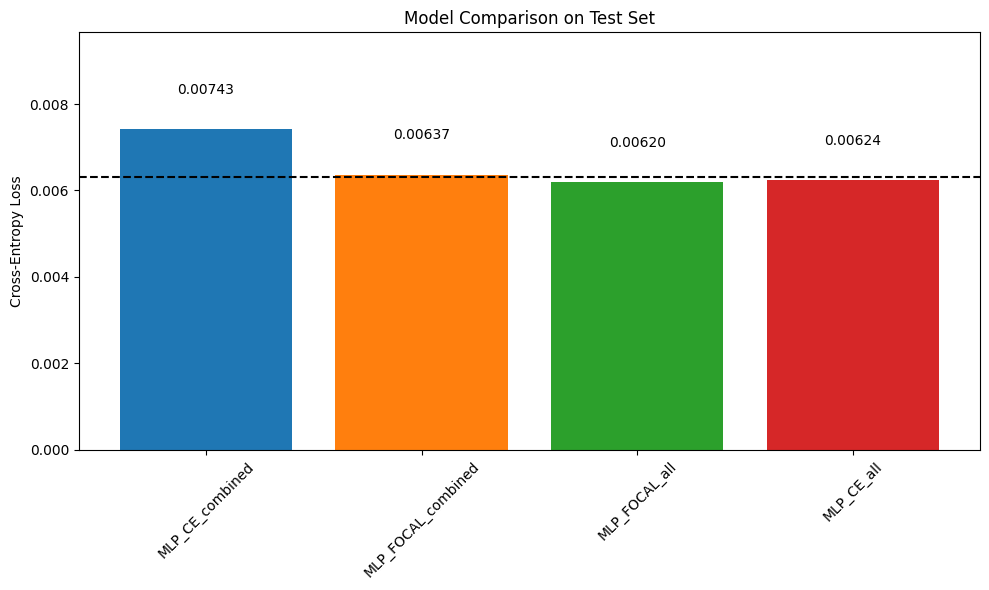

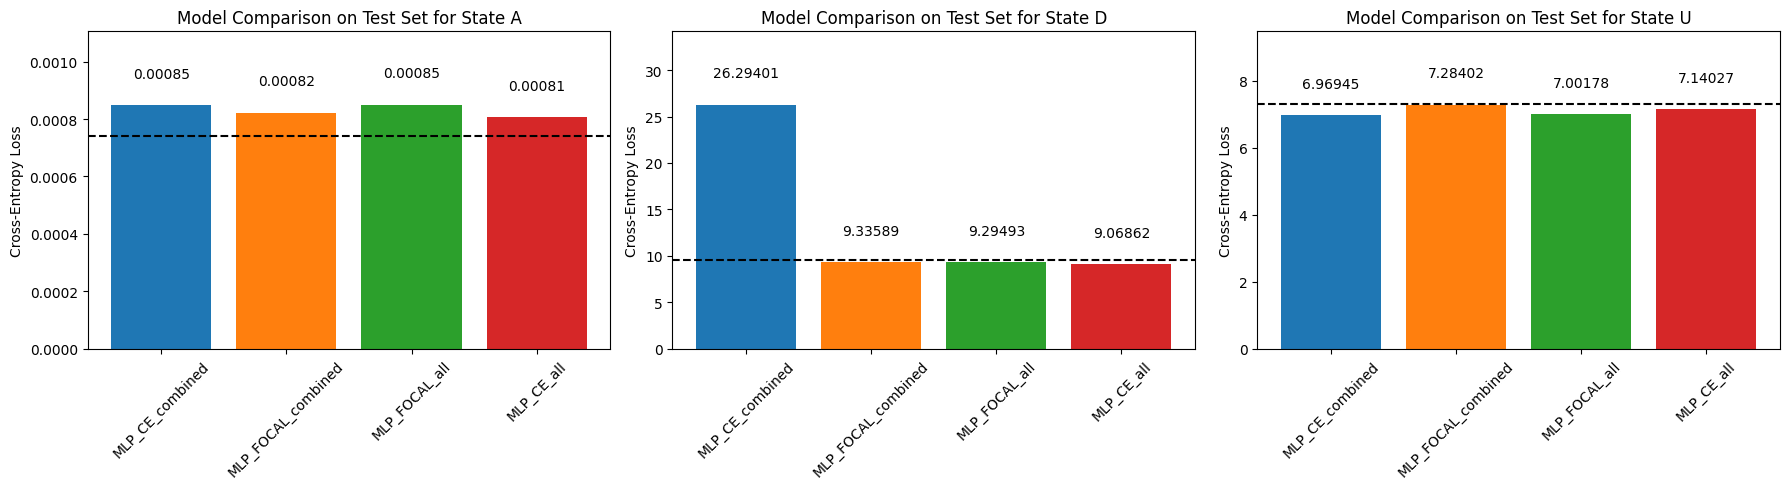

In [11]:
d = plot_loss_models(models_to_test, test_dataframes['A'])

In [12]:
def plot_prob_inference(feature: str, data_df: pd.DataFrame):
    colors_states = {'A': 'green', 'D': 'red', 'U': 'blue'}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    models_order = list(models_to_test.keys())
    if 'Frequency_Model' in models_order:
        models_order.remove('Frequency_Model')
    model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models_order)}
    if feature not in feature_names:
        raise ValueError(f"Feature '{feature}' not found in feature names.")


    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    # for i, final_state in enumerate(['A', 'D', 'U']):
        # ax = axs[i]
    feat_min = data_df[feature].min()
    feat_max = data_df[feature].max()
    feat_range = np.linspace(feat_min, feat_max, 100)
    gap_x = feat_range[1]-feat_range[0]

    inputs = data_df.copy()
    x_vals = data_df[feature].values
    weights = inputs['Data_weight'].values

    probs_models = {}

    for model_name, model in models_to_test.items():
        if model_name == 'Frequency_Model':
            continue
        mlp_features = model.feature_cols
        prob_mlp = model.predict(inputs[mlp_features])
        prob_mlp_plot = []
        for x in feat_range:
            f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
            if sum(weights[f_idx]) == 0:
                prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
                continue
            prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
        prob_mlp = np.array(prob_mlp_plot)
        probs_models[model_name] = prob_mlp
        
        # mlp_features = models[initial_state]['mlp'].feature_cols
        # prob_mlp = models[initial_state]['mlp'].predict(inputs[mlp_features])
        # prob_xgb_plot = []
        # prob_mlp_plot = []
        # for x in feat_range:
        #     f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
        #     if sum(weights[f_idx]) == 0:
        #         prob_xgb_plot.append(np.array([np.nan, np.nan, np.nan]))
        #         prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
        #         continue
        #     prob_xgb_plot.append(np.average(prob_xgb[f_idx], axis=0, weights=weights[f_idx]))
        #     prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
        # prob_xgb = np.array(prob_xgb_plot)
        # prob_mlp = np.array(prob_mlp_plot)



        # Compute empirical frequency

    empirical_feq = CE_min(data_df, mlp_features)

    avg_probs = []
    for x in feat_range:
        f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        f = empirical_feq[f_idx]
        w = weights[f_idx]
        if sum(w) == 0:
            avg_probs.append(np.array([np.nan, np.nan, np.nan]))
            continue
        avg_prob = np.average(f, axis=0, weights=w)
        # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        # if n_interval > 0:
        #     avg_prob = np.sum(f, axis=0) / n_interval
        # else:
        #     avg_prob = np.array([np.nan, np.nan, np.nan])
        avg_probs.append(avg_prob)

    freq_probs = models_to_test['Frequency_Model'].predict(inputs[mlp_features])
    avg_freq_probs = []
    for x in feat_range:
        f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
        f = freq_probs[f_idx]
        w = weights[f_idx]
        if sum(w) == 0:
            avg_freq_probs.append(np.array([np.nan, np.nan, np.nan]))
            continue
        avg_prob = np.average(f, axis=0, weights=w)
        avg_freq_probs.append(avg_prob)
    

        


    for j, end_state in enumerate(['A', 'D', 'U']):
        ax = axs[j]
        ax.axhline(y=avg_freq_probs[0][j], label=f'Frequency Model Avg', linestyle=':',  color='black')
        
        ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg', linestyle='-', linewidth=3, color=colors_states[end_state])
        for model_name, prob_mlp in probs_models.items():
            color_idx = list(models_to_test.keys()).index(model_name) % len(colors)

            ax.plot(feat_range, prob_mlp[:, j], label=f'{model_name}', linestyle='--', color=model_colors[model_name])
        # ax.plot(feat_range, prob_mlp[:, j], label=f'MLP to {end_state}', linestyle='--', color=colors[end_state])

        ax.set_title(f'End State: {end_state}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Predicted Transition Probability')
        ax.legend()
    # vals4axis = np.concatenate([prob_xgb[:, [k for k in range(3) if k != i]].flatten(), prob_mlp[:, [k for k in range(3) if k != i]].flatten()])
    # vals4axis = vals4axis[~np.isnan(vals4axis)]
    # ax.set_ylim(0, 5 * np.mean(vals4axis))
    plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({techno})', fontsize=16)
    plt.tight_layout()


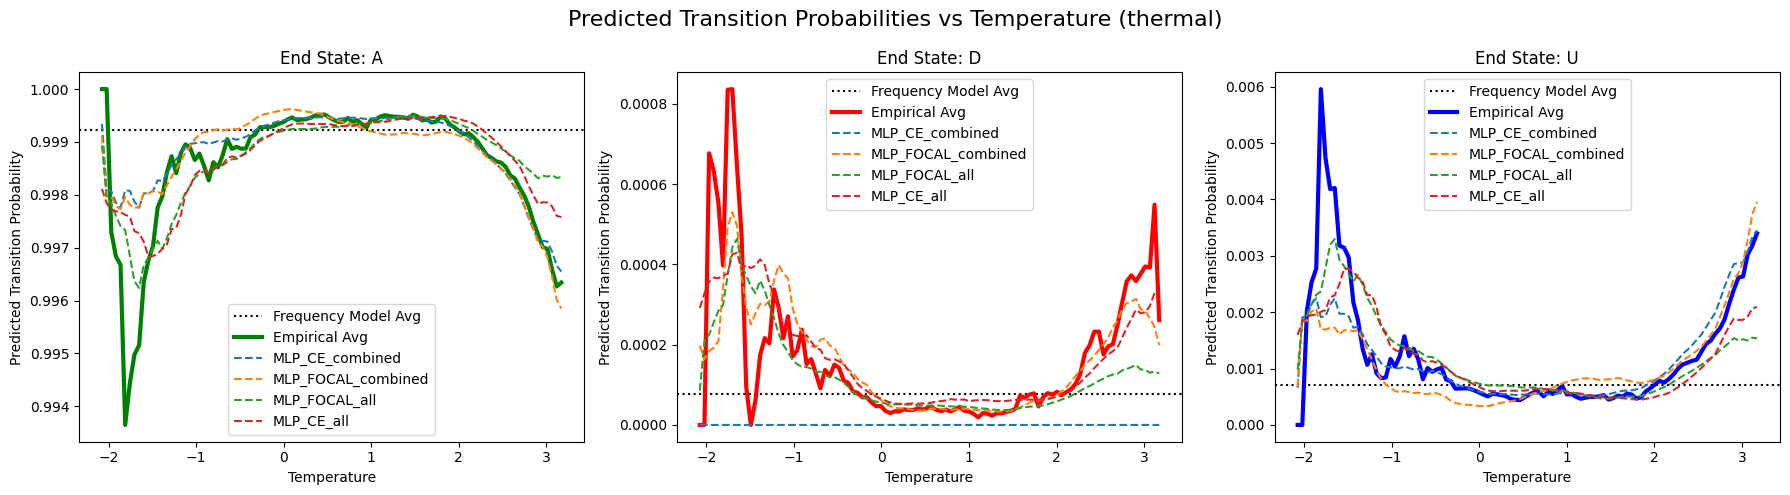

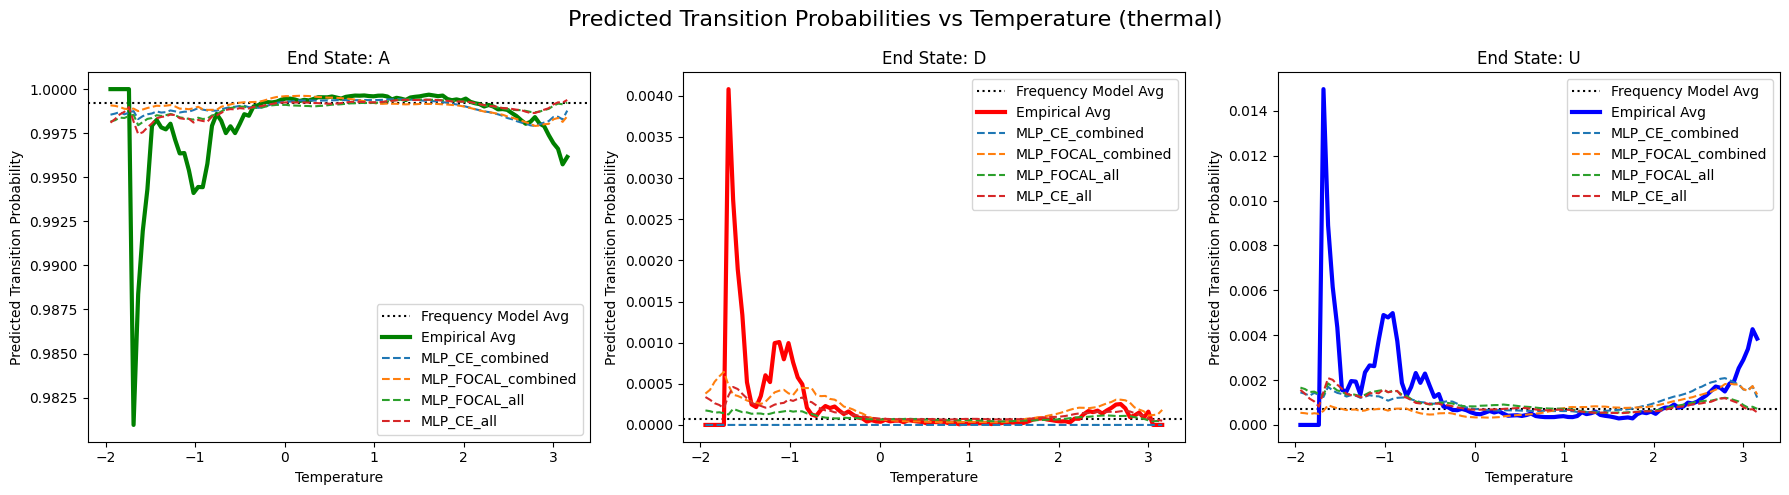

In [13]:
plot_prob_inference('Temperature', train_dataframes['A'])
plot_prob_inference('Temperature', test_dataframes['A'])

# All transition prob

In [6]:
class transition_probability:
    def __init__(self, models: dict[str, im.MLP], feature_cols: list[str]):
        self.models = models  # Dictionary with keys as 'A', 'D', 'U' and values as corresponding models
        self.feature_cols = feature_cols

    def predict(self, X):
        probs = np.empty((3, len(X), 3))  # Assuming three states: A, D, U
        for i, (state, model) in enumerate(self.models.items()):
            probs[i,:,:] = model.predict(X[self.feature_cols].copy())  # Assuming binary classification with positive class at index 1

        return probs

        # Combine probabilities into a single array
        combined_probs = np.vstack((probs['A'], probs['D'], probs['U'])).T
        return combined_probs

In [9]:
class freq_model_wrapper:
    def __init__(self, freq_model, feature_names):
        self.freq_model = freq_model
        self.feature_cols = feature_names
    
    def predict(self, X):
        return self.freq_model(X[self.feature_cols])

In [10]:
importlib.reload(im)
transition_prob_models = {}

# Combined CE model
combined_ce_A = composition_model()
combined_ce_A.load_D_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
combined_ce_A.load_U_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')
combined_ce_D = composition_model()
combined_ce_D.load_A_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_D_to_A_State_New York.pth", model_type='mlp')
combined_ce_D.load_U_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_D_to_U_State_New York.pth", model_type='mlp')
combined_ce_U = composition_model()
combined_ce_U.load_A_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_U_to_A_State_New York.pth", model_type='mlp')
combined_ce_U.load_D_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_U_to_D_State_New York.pth", model_type='mlp')
ce_combined_model = transition_probability({'A': combined_ce_A, 'D': combined_ce_D, 'U': combined_ce_U}, feature_names)
transition_prob_models['CE_Combined'] = ce_combined_model


# Combined focal model (constant)
focal_cons_A = composition_model()
focal_cons_A.load_D_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
focal_cons_A.load_U_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')
focal_cons_D = composition_model()
focal_cons_D.load_A_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_D_to_A_State_New York.pth", model_type='mlp')
focal_cons_D.load_U_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_D_to_U_State_New York.pth", model_type='mlp')
focal_cons_U = composition_model()
focal_cons_U.load_A_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_U_to_A_State_New York.pth", model_type='mlp')
focal_cons_U.load_D_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_U_to_D_State_New York.pth", model_type='mlp')
focal_combined_model = transition_probability({'A': focal_cons_A, 'D': focal_cons_D, 'U': focal_cons_U}, feature_names)
transition_prob_models['FOCAL_Combined'] = focal_combined_model

# # Combined focal model (scheduled)
# focal_sched_A = composition_model()
# focal_sched_A.load_D_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
# focal_sched_A.load_U_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')
# focal_sched_D = composition_model()
# focal_sched_D.load_A_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_D_to_A_State_New York.pth", model_type='mlp')
# focal_sched_D.load_U_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_D_to_U_State_New York.pth", model_type='mlp')
# focal_sched_U = composition_model()
# focal_sched_U.load_A_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_U_to_A_State_New York.pth", model_type='mlp')
# focal_sched_U.load_D_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_U_to_D_State_New York.pth", model_type='mlp')
# focal_combined_model = transition_probability({'A': focal_sched_A, 'D': focal_sched_D, 'U': focal_sched_U}, feature_names)
# transition_prob_models['FOCAL_SCHEDULED_Combined'] = focal_combined_model


# All-in-one CE model
mlp_loader = im.MLP(verbose=False)
ce_allA = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_all_State_New York.pth")
mlp_loader = im.MLP(verbose=False)
ce_allD = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_D_to_all_State_New York.pth")
mlp_loader = im.MLP(verbose=False)
ce_allU = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_U_to_all_State_New York.pth")
ce_all_model = transition_probability({'A': ce_allA, 'D': ce_allD, 'U': ce_allU}, feature_names)
transition_prob_models['CE'] = ce_all_model


# All-in-one focal model (constant)
mlp_loader = im.MLP(verbose=False)
focal_allA = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_A_to_all_State_New York.pth")
mlp_loader = im.MLP(verbose=False)
focal_allD = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_D_to_all_State_New York.pth")
mlp_loader = im.MLP(verbose=False)
focal_allU = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_U_to_all_State_New York.pth")
focal_all_model = transition_probability({'A': focal_allA, 'D': focal_allD, 'U': focal_allU}, feature_names)
transition_prob_models['FOCAL'] = focal_all_model

# All-in-one CE PJM+ model
mlp_loader = im.MLP(verbose=False)
ce_allA_pjm = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_all_State_all.pth")
mlp_loader = im.MLP(verbose=False)
ce_allD_pjm = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_D_to_all_State_all.pth")
mlp_loader = im.MLP(verbose=False)
ce_allU_pjm = mlp_loader.load_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_U_to_all_State_all.pth")
ce_all_model = transition_probability({'A': ce_allA_pjm, 'D': ce_allD_pjm, 'U': ce_allU_pjm}, feature_names)
transition_prob_models['CE_PJM'] = ce_all_model

# All-in-one focal model (constant) all states
mlp_loader = im.MLP(verbose=False)
focal_allA_pjm = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_A_to_all_State_all.pth")
mlp_loader = im.MLP(verbose=False)
focal_allD_pjm = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_D_to_all_State_all.pth")
mlp_loader = im.MLP(verbose=False)
focal_allU_pjm = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_U_to_all_State_all.pth")
focal_all_model = transition_probability({'A': focal_allA_pjm, 'D': focal_allD_pjm, 'U': focal_allU_pjm}, feature_names)
transition_prob_models['FOCAL_PJM'] = focal_all_model

# # All-in-one focal model (scheduled)
# mlp_loader = im.MLP(verbose=False)
# focal_allA = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_A_to_all_State_New York.pth")
# mlp_loader = im.MLP(verbose=False)
# focal_allD = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_D_to_all_State_New York.pth")
# mlp_loader = im.MLP(verbose=False)
# focal_allU = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_SCHEDULED_Tech_thermal_fr_U_to_all_State_New York.pth")
# focal_all_model = transition_probability({'A': focal_allA, 'D': focal_allD, 'U': focal_allU}, feature_names)
# transition_prob_models['FOCAL_SCHEDULED_All_in_One'] = focal_all_model

# Frequency-based model
freqA = freq_model_wrapper(freq_model(train_dataframes['A'], feature_names, ['Final_gen_state']), feature_names) 
freqD = freq_model_wrapper(freq_model(train_dataframes['D'], feature_names, ['Final_gen_state']), feature_names) 
freqU = freq_model_wrapper(freq_model(train_dataframes['U'], feature_names, ['Final_gen_state']), feature_names) 
fr_model = transition_probability({'A': freqA, 'D': freqD, 'U': freqU}, feature_names)
transition_prob_models['Frequency_Model'] = fr_model


# Combination of best models
# best_model = transition_probability({'A': ce_allA, 'D': freqD, 'U': ce_allU}, feature_names)
# transition_prob_models['Best_Combination'] = best_model

bestA = composition_model()
bestA.load_D_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_A_to_D_State_New York.pth", model_type='mlp')
bestA.load_U_model("../Results/Models/model_MLP_CE_Tech_thermal_fr_A_to_U_State_New York.pth", model_type='mlp')
# bestA.model_to_D = ce_allA
# bestA.missing.remove('D')

bestD = freq_model_wrapper(freq_model(train_dataframes['D'], feature_names, ['Final_gen_state']), feature_names)

# bestU = composition_model()
# bestU.load_A_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_U_to_A_State_New York.pth", model_type='mlp')
# bestU.model_to_D = focal_cons_U
# bestU.missing.remove('D')

mlp_loader = im.MLP(verbose=False)
bestU = mlp_loader.load_model("../Results/Models/model_MLP_FOCAL_CONSTANT_Tech_thermal_fr_U_to_all_State_New York.pth")

best_model = transition_probability({'A': ce_allA_pjm, 'D': focal_allD_pjm, 'U': ce_allU}, feature_names)
# transition_prob_models['Best_Combination'] = best_model

Sequential(
  (linear_0): Linear(in_features=43, out_features=128, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=128, out_features=128, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=64, out_features=64, bias=True)
  (activation_3): ReLU()
  (linear_4): Linear(in_features=64, out_features=64, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=64, out_features=64, bias=True)
  (activation_5): ReLU()
  (linear_6): Linear(in_features=64, out_features=64, bias=True)
  (activation_6): ReLU()
  (linear_7): Linear(in_features=64, out_features=64, bias=True)
  (activation_7): ReLU()
  (linear_8): Linear(in_features=64, out_features=64, bias=True)
  (activation_8): ReLU()
  (linear_9): Linear(in_features=64, out_features=64, bias=True)
  (activation_9): ReLU()
  (linear_10): Linear(in_features=64, out_features=64, bias=True)
  (activation_10):

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickl

In [11]:
def plot_loss_models_transitions(models, data_dict):
    for init_idx, initial_state in enumerate(['A', 'D', 'U']):
        data_df = data_dict[initial_state]

        model_scores = {}

        for model_name, model in models.items():
            model_scores[model_name] = {}
            targets = data_df['Final_gen_state'].to_numpy()
            weights = data_df['Data_weight'].to_numpy()
            probs = model.predict(data_df[model.feature_cols].copy())[init_idx]
            ce = cross_entropy(probs, targets, weights)
            model_scores[model_name]['Overall'] = ce
            for sname, s in integer_encoding['Final_gen_state'].items():
                state_df = data_df[data_df['Final_gen_state'] == s].copy()
                targets = state_df['Final_gen_state'].to_numpy()
                weights = state_df['Data_weight'].to_numpy()
                probs = model.predict(state_df[model.feature_cols].copy())[init_idx]
                ce_loss = cross_entropy(probs, targets, weights)
                model_scores[model_name][s] = ce_loss

        # model_scores['Frequency_Model'] = {}
        # targets = data_df['Final_gen_state'].to_numpy()
        # weights = data_df['Data_weight'].to_numpy()
        # freq_p = freq_model(data_df, feature_names, ['Final_gen_state'])
        # probs_freq = freq_p(data_df[feature_names])
        # ce_freq = cross_entropy(probs_freq, targets, weights)
        # model_scores['Frequency_Model']['Overall'] = ce_freq
        # for sname, s in integer_encoding['Final_gen_state'].items():
        #     state_df = data_df[data_df['Final_gen_state'] == s].copy()
        #     targets = state_df['Final_gen_state'].to_numpy()
        #     weights = state_df['Data_weight'].to_numpy()
        #     freq_p = freq_model(data_df, feature_names, ['Final_gen_state'])
        #     probs_freq = freq_p(state_df[feature_names])
        #     ce_freq = cross_entropy(probs_freq, targets, weights)
        #     model_scores['Frequency_Model'][s] = ce_freq

        model_scores_df = pd.DataFrame(model_scores)
        # models_order = ['MLP_CE_combined', 'MLP_FOCAL_combined', 'MLP_FOCAL_all']
        models_order = model_scores_df.columns.tolist()
        if 'Frequency_Model' in models_order:
            models_order.remove('Frequency_Model')
        models_order = [m for m in models_order if m in model_scores_df.columns]
        model_scores_df = model_scores_df[models_order+['Frequency_Model']]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models_order)}

        fig, ax = plt.subplots(figsize=(10, 6))
        res = model_scores_df.loc['Overall']
        res_plot = res[models_order]
        freq = model_scores_df.loc['Overall']['Frequency_Model']
        ax.bar(res_plot.index, res_plot.values, color=[model_colors[m] for m in res_plot.index])
        ax.axhline(y=freq, color='black', linestyle='--')
        ax.set_ylabel('Cross-Entropy Loss')
        ax.set_title('Model Comparison on Test Set')
        for j, v in enumerate(res_plot.values):
            ax.text(j, v + 0.1*max(res_plot.values), f"{v:.5f}", ha='center', va='bottom')
        

        ax.set_ylim(0, max(res_plot.values)*1.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(1,3,figsize=(18, 5))
        for sname, s in integer_encoding['Final_gen_state'].items():
            res = model_scores_df.loc[s].copy()
            res = res.dropna()
            res_plot = res[models_order]
            freq = model_scores_df.loc[s]['Frequency_Model']
            ax[s].bar(res_plot.index, res_plot.values, color=[model_colors[m] for m in res_plot.index])
            ax[s].axhline(y=freq, color='black', linestyle='--')
            ax[s].set_ylabel('Cross-Entropy Loss')
            ax[s].set_title(f'Model Comparison on Test Set for State {sname}')
            plt.sca(ax[s])
            plt.xticks(rotation=45)
            for j, v in enumerate(res_plot.values):
                ax[s].text(j, v + 0.1*max(res_plot.values), f"{v:.5f}", ha='center', va='bottom')
            ax[s].set_ylim(0, max(res_plot.values)*1.3)
        plt.tight_layout()
        plt.show()


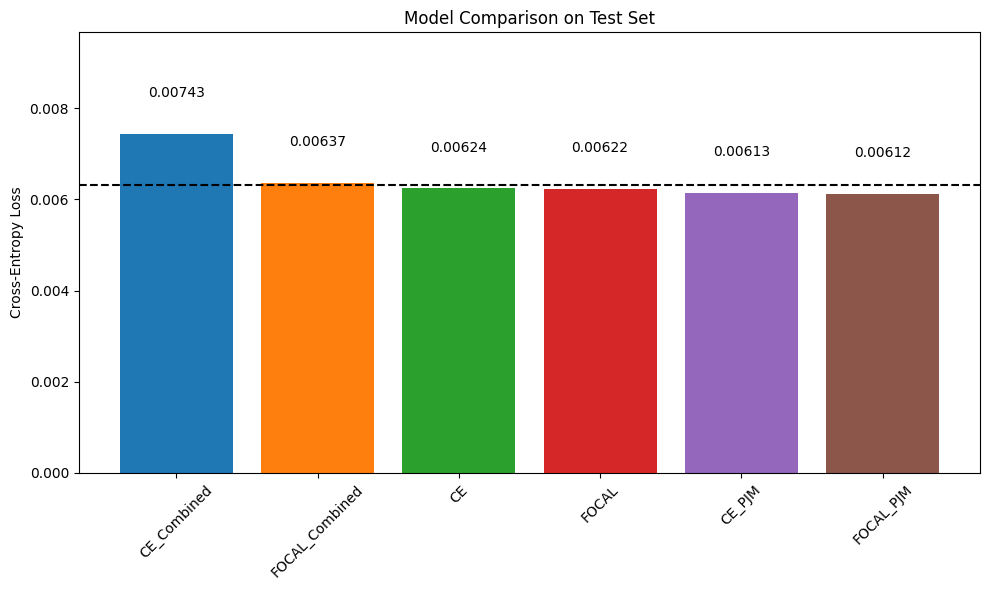

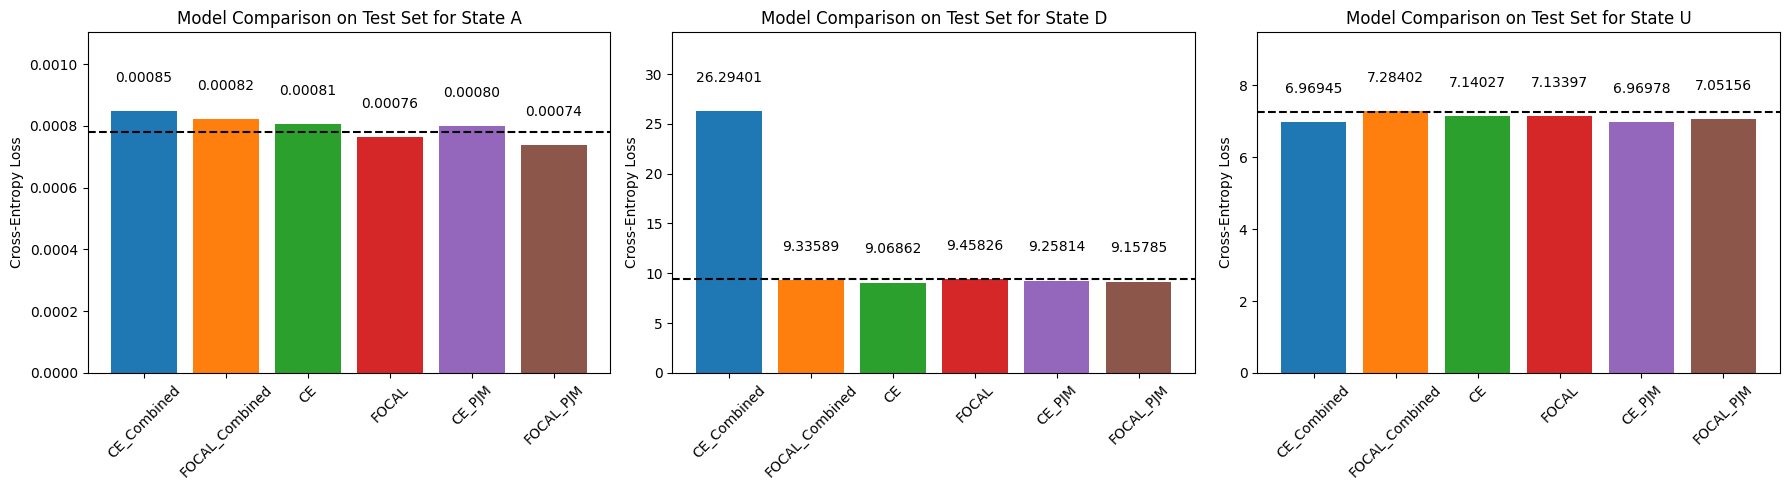

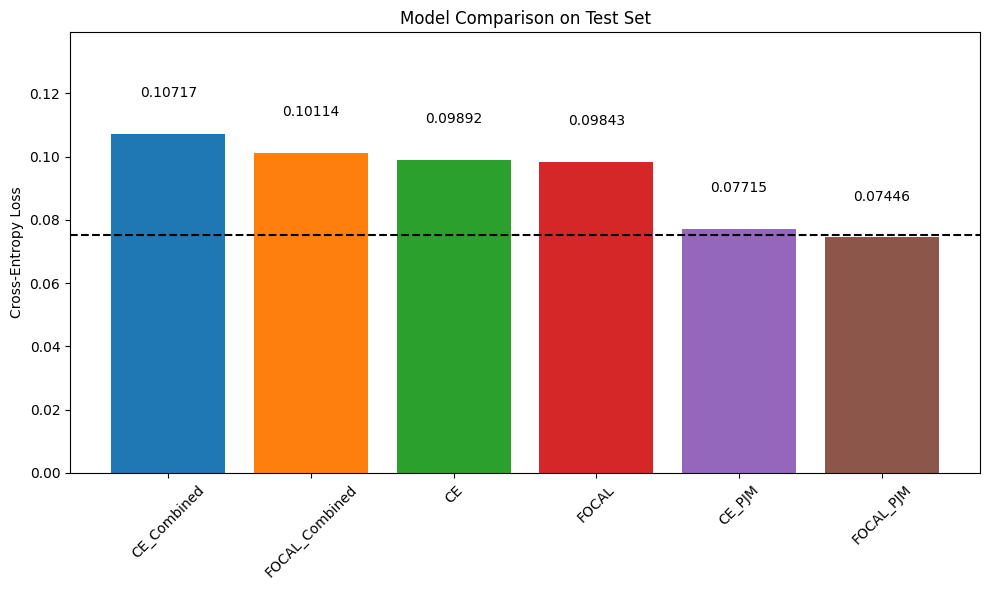

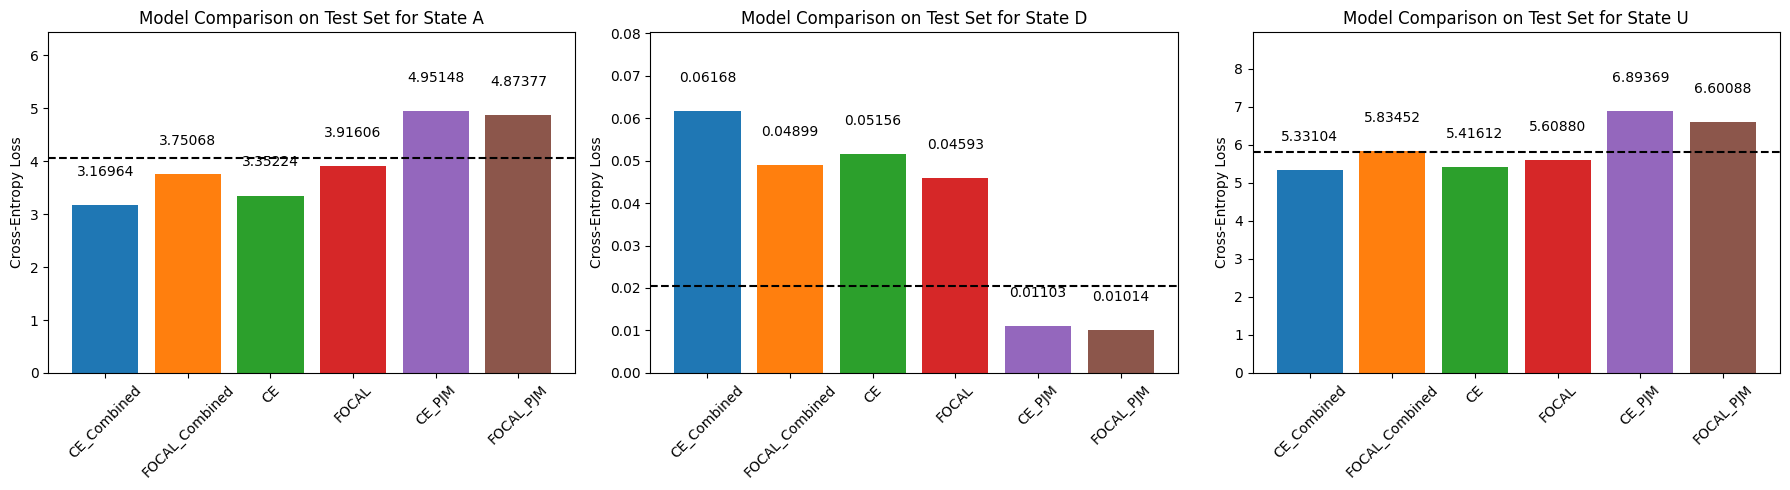

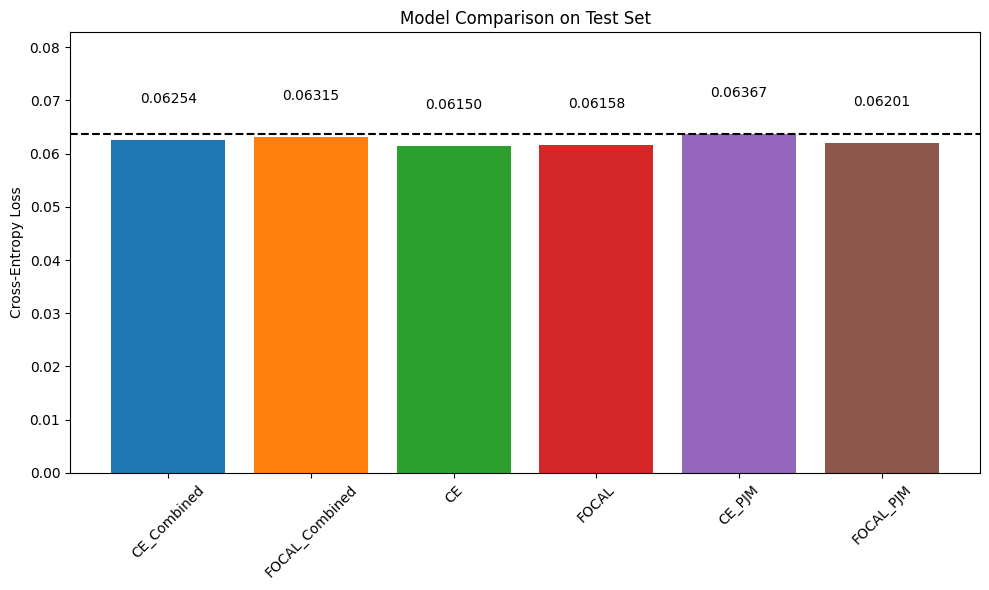

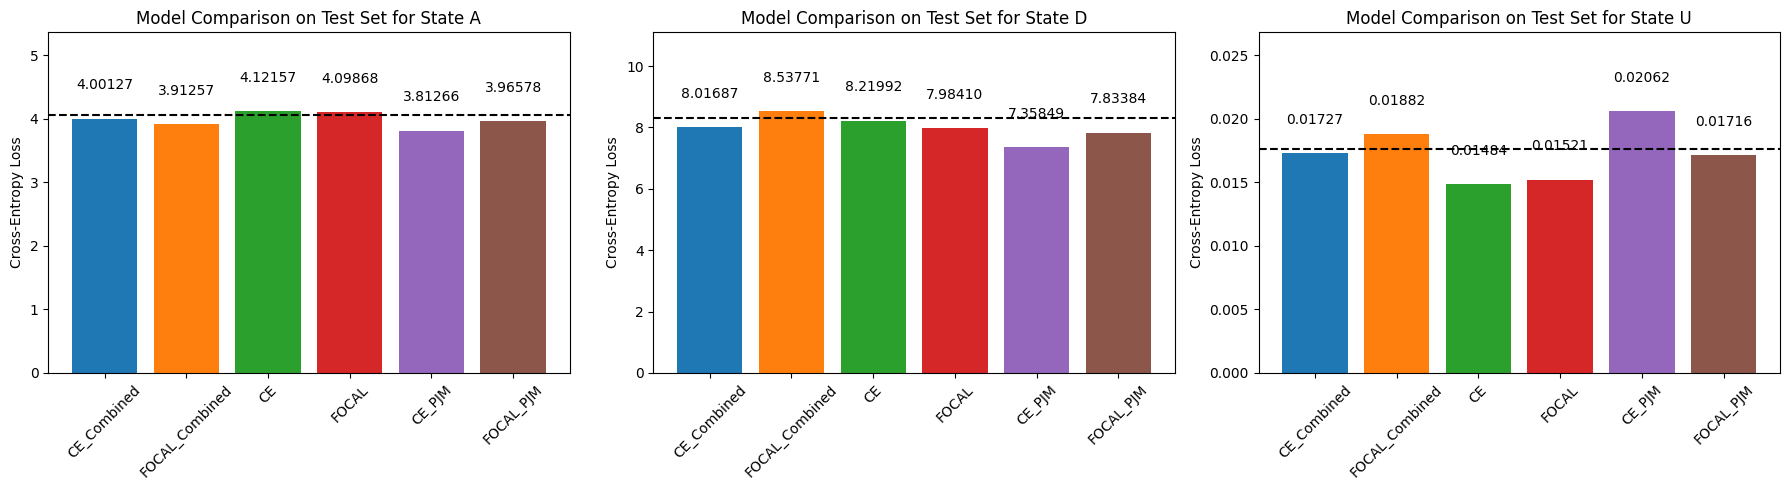

In [14]:
plot_loss_models_transitions(transition_prob_models, test_dataframes)

In [15]:
def plot_prob_inference_transitions(feature: str, models: dict, data_dicts: pd.DataFrame):
    colors_states = {'A': 'green', 'D': 'red', 'U': 'blue'}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    models_order = list(models.keys())
    if 'Frequency_Model' in models_order:
        models_order.remove('Frequency_Model')
    model_colors = {model: colors[i % len(colors)] for i, model in enumerate(models_order)}
    if feature not in feature_names:
        raise ValueError(f"Feature '{feature}' not found in feature names.")

    for init_idx, initial_state in enumerate(['A', 'D', 'U']):
        data_df = data_dicts[initial_state]

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        # for i, final_state in enumerate(['A', 'D', 'U']):
            # ax = axs[i]
        feat_min = data_df[feature].min()
        feat_max = data_df[feature].max()
        feat_range = np.linspace(feat_min, feat_max, 100)
        gap_x = feat_range[1]-feat_range[0]

        inputs = data_df.copy()
        x_vals = data_df[feature].values
        weights = inputs['Data_weight'].values

        probs_models = {}

        for model_name, model in models.items():
            if model_name == 'Frequency_Model':
                continue
            mlp_features = model.feature_cols
            prob_mlp = model.predict(inputs[mlp_features])[init_idx]
            prob_mlp_plot = []
            for x in feat_range:
                f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
                if sum(weights[f_idx]) == 0:
                    prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
                    continue
                prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
            prob_mlp = np.array(prob_mlp_plot)
            probs_models[model_name] = prob_mlp
            
            # mlp_features = models[initial_state]['mlp'].feature_cols
            # prob_mlp = models[initial_state]['mlp'].predict(inputs[mlp_features])
            # prob_xgb_plot = []
            # prob_mlp_plot = []
            # for x in feat_range:
            #     f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
            #     if sum(weights[f_idx]) == 0:
            #         prob_xgb_plot.append(np.array([np.nan, np.nan, np.nan]))
            #         prob_mlp_plot.append(np.array([np.nan, np.nan, np.nan]))
            #         continue
            #     prob_xgb_plot.append(np.average(prob_xgb[f_idx], axis=0, weights=weights[f_idx]))
            #     prob_mlp_plot.append(np.average(prob_mlp[f_idx], axis=0, weights=weights[f_idx]))
            # prob_xgb = np.array(prob_xgb_plot)
            # prob_mlp = np.array(prob_mlp_plot)



            # Compute empirical frequency

        empirical_feq = CE_min(data_df, mlp_features)

        avg_probs = []
        for x in feat_range:
            f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
            f = empirical_feq[f_idx]
            w = weights[f_idx]
            if sum(w) == 0:
                avg_probs.append(np.array([np.nan, np.nan, np.nan]))
                continue
            avg_prob = np.average(f, axis=0, weights=w)
            # n_interval = np.sum((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
            # if n_interval > 0:
            #     avg_prob = np.sum(f, axis=0) / n_interval
            # else:
            #     avg_prob = np.array([np.nan, np.nan, np.nan])
            avg_probs.append(avg_prob)

        freq_probs = models['Frequency_Model'].predict(inputs[mlp_features])[init_idx]
        avg_freq_probs = []
        for x in feat_range:
            f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
            f = freq_probs[f_idx]
            w = weights[f_idx]
            if sum(w) == 0:
                avg_freq_probs.append(np.array([np.nan, np.nan, np.nan]))
                continue
            avg_prob = np.average(f, axis=0, weights=w)
            avg_freq_probs.append(avg_prob)
        

            


        for j, end_state in enumerate(['A', 'D', 'U']):
            ax = axs[j]
            ax.axhline(y=avg_freq_probs[0][j], label=f'Frequency Model Avg', linestyle=':',  color='black')
            
            ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg', linestyle='-', linewidth=3, color=colors_states[end_state])
            for model_name, prob_mlp in probs_models.items():
                color_idx = list(models.keys()).index(model_name) % len(colors)

                ax.plot(feat_range, prob_mlp[:, j], label=f'{model_name}', linestyle='--', color=model_colors[model_name])
            # ax.plot(feat_range, prob_mlp[:, j], label=f'MLP to {end_state}', linestyle='--', color=colors[end_state])

            ax.set_title(f'End State: {end_state}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Predicted Transition Probability')
            ax.legend()
        # vals4axis = np.concatenate([prob_xgb[:, [k for k in range(3) if k != i]].flatten(), prob_mlp[:, [k for k in range(3) if k != i]].flatten()])
        # vals4axis = vals4axis[~np.isnan(vals4axis)]
        # ax.set_ylim(0, 5 * np.mean(vals4axis))
        plt.suptitle(f'Predicted Transition Probabilities vs {feature} ({techno})', fontsize=16)
        plt.tight_layout()


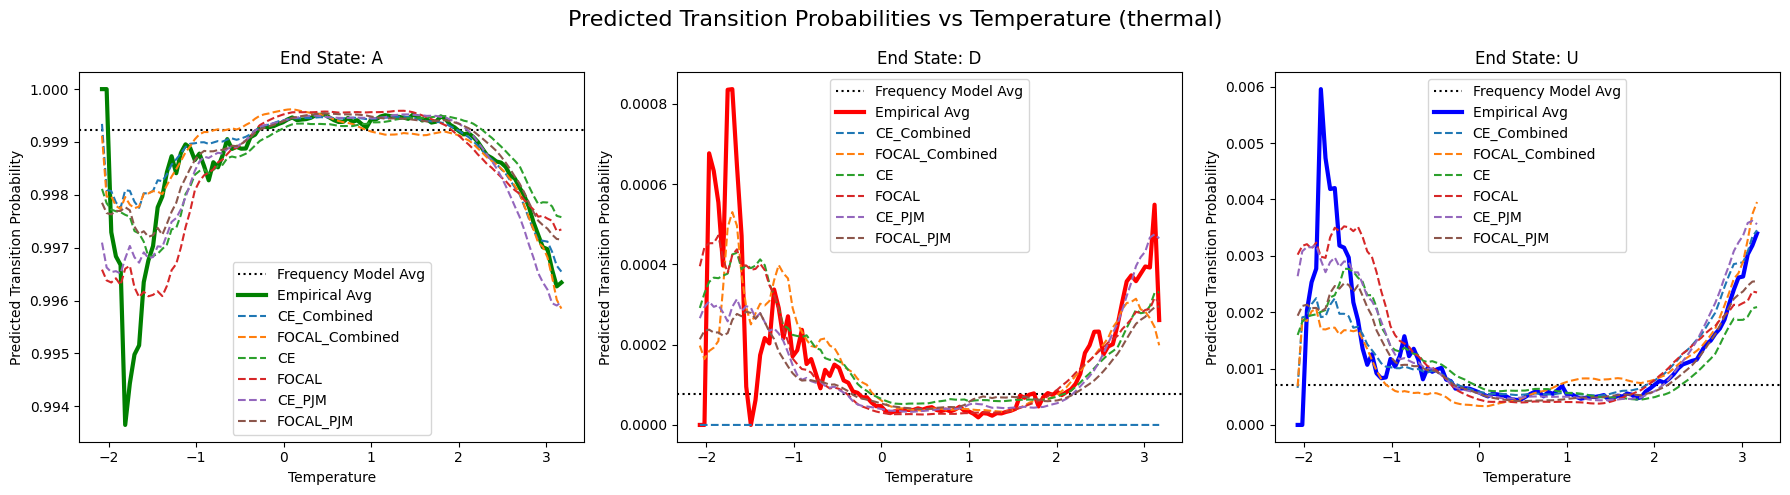

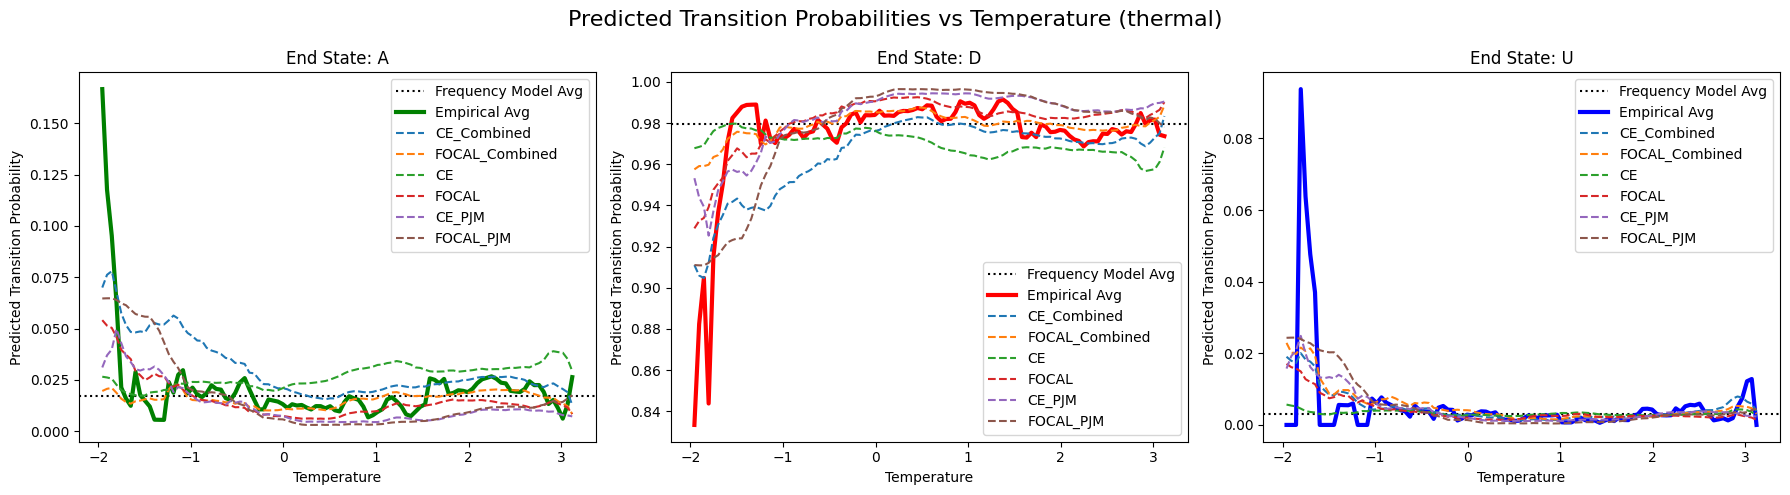

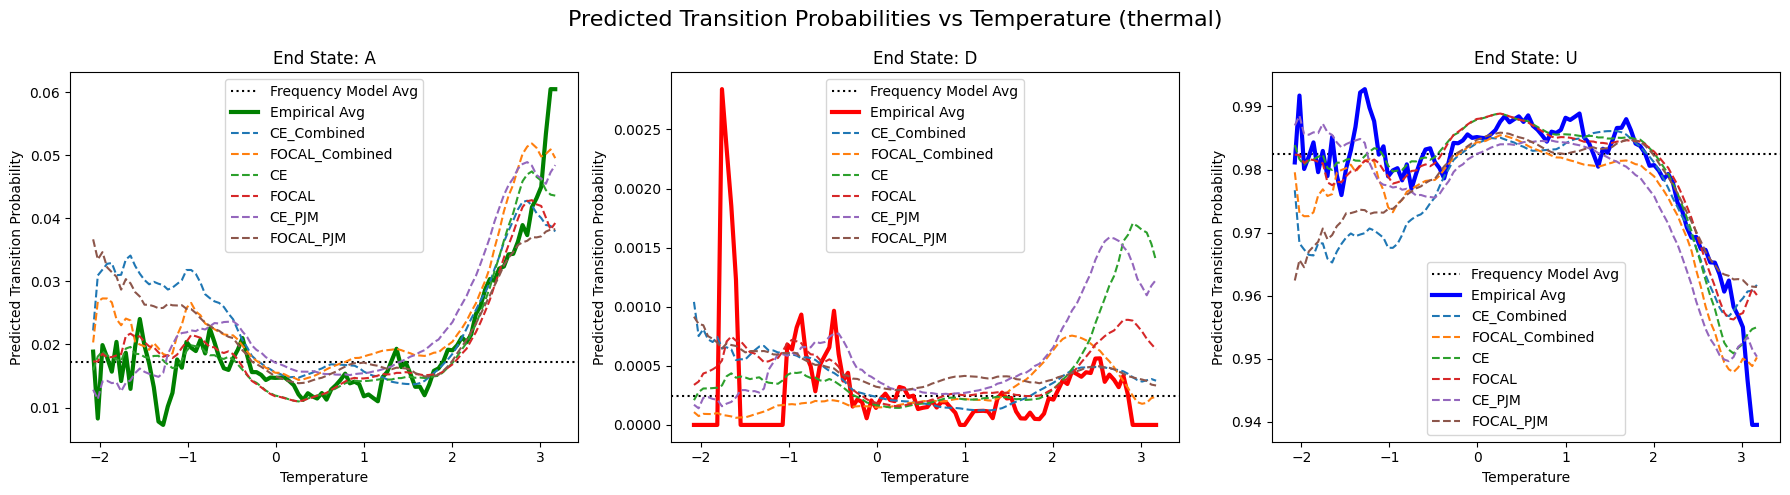

In [16]:
plot_prob_inference_transitions('Temperature', transition_prob_models, train_dataframes)

# Logistic regression baseline

In [17]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']
state = 'New York'
if 'State' in feature_names_base:
    feature_names_base.remove('State')

# ---------- Merge + label prep ----------
train_val_df, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                            weather_data_path=weather_data_file,
                                                                                            power_load_data_path=power_load_file,
                                                                                            feature_names=feature_names_base,
                                                                                            cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                            state_filter = state,
                                                                                            state_one_hot=False,
                                                                                            initial_MC_state_filter='all',
                                                                                            final_MC_state_target = 'all',
                                                                                            technology_filter=technologies,
                                                                                            technology_one_hot=True,
                                                                                            test_periods=test_periods,
                                                                                            dropNA = True,
                                                                                            feature_na_drop_threshold = 0.2,
                                                                                            )
                                                                            


# subset_length = 100
# train_val_df = train_val_df.iloc[0:subset_length].copy().reset_index(drop=True)
print(f"Train/Val Dataset shape: {train_val_df.shape}")


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

train_val_df_A = train_val_df.loc[train_val_df['Initial_gen_state']==0].copy().reset_index(drop=True)
load_stand_params = pd.read_csv('../DATA/standardization_params_by_state.csv')
train_val_df_A, feature_names  = ppd.preprocess_baseline_logistic_regression_data(train_val_df_A, load_stand_params)

train_val_df_D = train_val_df.loc[train_val_df['Initial_gen_state']!=0].copy().reset_index(drop=True)
load_stand_params = pd.read_csv('../DATA/standardization_params_by_state.csv')
train_val_df_D, feature_names  = ppd.preprocess_baseline_logistic_regression_data(train_val_df_D, load_stand_params)

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']
Train/Val Dataset shape: (157381, 48)
Standardized features (32): ['CDD', '24h_min_load', 'Precipitation', 'Tmax', 'Wet_bulb_temperature', 'Precip_3d', 'HDD3d', '2d_load_sum', '1d_load_sum', 'Snow_depth', 'Tmean', 'Heat_index', 'HDD', 'Tmin', 'Hourly_load_change', 'Wind_chill', 'Extreme_heat', 'Temperature', 'Station_level_pressure', 'Pressure_3hr_change', 'Precip_1d', '24h_max_load', 'FDD3d', 'CDD3d', 'FDD', 'Load', 'Sea_level_pressure', 'Wind_s

In [18]:
importlib.reload(im)
mA = im.LogisticRegressionBaseline(verbose=False)
mA.build_model(target_cols=['Final_gen_state'])
mA.prepare_data(train_val_df_A,  split_ratios=(0.8, 0.2))
train_kw = {"batch_size": 512, "burn_in": 10000, "device": "cpu", "early_stopping": True, "epochs": 100, "flat_delta": 2e-05, "flat_mode": "iqr", "flat_patience": 10, "grad_clip_norm": 1.0, "lambda_reg": 0.001, "lr": 0.002, "lr_scheduler": "linear", "min_delta": 1e-05, "optimizer": "adam", "patience": 10, "regularization_type": "L2", "rel_flat": 0.002, "weights_data": True}
mA.train_model(**train_kw)

mD = im.LogisticRegressionBaseline(verbose=False)
mD.build_model(target_cols=['Final_gen_state'])
mD.prepare_data(train_val_df_D,  split_ratios=(0.8, 0.2))
train_kw = {"batch_size": 512, "burn_in": 10000, "device": "cpu", "early_stopping": True, "epochs": 100, "flat_delta": 2e-05, "flat_mode": "iqr", "flat_patience": 10, "grad_clip_norm": 1.0, "lambda_reg": 0.0005, "lr": 0.0002, "lr_scheduler": "constant", "min_delta": 1e-05, "optimizer": "adam", "patience": 10, "regularization_type": "L2", "rel_flat": 0.002, "weights_data": True}
mD.train_model(**train_kw)

In [19]:
class trans_prob_logist:
    def __init__(self, model_A: im.LogisticRegressionBaseline, model_D: im.LogisticRegressionBaseline):
        self.model_A = model_A
        self.model_D = model_D

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        predA = self.model_A.predict(X).flatten()
        predD = self.model_D.predict(X).flatten()
        # Combine predictions into transition probability
        probs = np.empty((2, X.shape[0], 2))
        probs[0, :, 1] = predA  # P(A->D)
        probs[0, :, 0] = 1 - predA  # P(A->A)
        probs[1, :, 1] = predD  # P(D->D)
        probs[1, :, 0] = 1 - predD  # P(D->A)
        return probs


In [20]:
logistic_regression_model = trans_prob_logist(mA, mD)


In [21]:

def get_stationary_distribution(transition_probability_matrix: np.ndarray) -> np.ndarray:
    """Computes the stationary distribution of a Markov chain given its transition probability matrix.
    INPUTS:
    - transition_probability_matrix: 2D numpy array of shape (n_states, n_states)
    OUTPUTS:
    - stationary_distribution: 1D numpy array of shape (n_states,)
    """
    assert transition_probability_matrix.ndim == 2, "Transition probability matrix must be 2D"
    assert transition_probability_matrix.shape[0] == transition_probability_matrix.shape[1], "Transition probability matrix must be square"
    
    n_states = transition_probability_matrix.shape[0]
    A = np.transpose(transition_probability_matrix) - np.eye(n_states)
    A = np.vstack([A, np.ones(n_states)])
    b = np.zeros(n_states + 1)
    b[-1] = 1.0

    A = A.astype(float)
    b = b.astype(float)

    stationary_distribution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    return stationary_distribution

def generate_unavailable_capacity_scenario_per_gen_logistic(
    covariates_inputs_df: pd.DataFrame,
    generators_data_df: pd.DataFrame,
    transition_model: dict,
    num_scenarios: int = 1000,
    min_scenarios_per_gen: int = 10,
) -> dict:
    """
    Generate per-generator state scenarios from ML-based transition models.

    Internals:
    - Uses integer encoding for states: 0 -> 'A', 1 -> 'D', 2 -> 'U'.
    - Vectorizes:
        * Transition probabilities into a (3, T, 3) array.
        * Scenario simulation over K scenarios per generator.

    INPUTS:
    - covariates_inputs_df : DataFrame with columns
        ['Datetime_UTC'] + features needed by each model.
      Must be sorted by Datetime_UTC (if not, we sort internally).
    - generators_data_df : DataFrame with at least columns
        ['UnitID', 'Start date', 'End date'].
    - models : dict mapping initial-state label -> fitted model, e.g.
        {'A': model_A, 'D': model_D, 'U': model_U}
      Each model must expose `.feature_cols` and `.predict(X)` returning
      probs with columns ordered as [P(A), P(D), P(U)].
    - num_scenarios : Target number of *aggregate* scenarios. We generate
      K scenarios per generator such that K^G ≳ num_scenarios, where
      G = number of generators.

    OUTPUT:
    - scenarios_per_gen : dict[unit_id -> list[pd.DataFrame]]
        Each DataFrame has columns ['Datetime_UTC', 'Gen_state', 'UnitID'].
    """
    # ---- State encoding ----
    state_labels = ["A", "D"]
    label_to_idx = {s: i for i, s in enumerate(state_labels)}
    idx_to_label = {i: s for s, i in label_to_idx.items()}
    idx_to_label[-1] = "N/A"  # for uninitialized states
    n_states = len(state_labels)

    # ---- Ensure time ordering + extract times as numpy ----
    cov_df = covariates_inputs_df.sort_values("Datetime_UTC").reset_index(drop=True)
    times = cov_df["Datetime_UTC"].to_numpy()
    T = len(times)

    # ---- Precompute transition probabilities as numpy array ----
    # P_all[from_state, t, to_state] with shape (3, T, 3)
    P_all = transition_model.predict(cov_df)
    # P_all = np.empty((n_states, T, n_states), dtype=np.float64)

    # for from_label, model in models.items():
    #     if from_label not in label_to_idx:
    #         raise KeyError(f"Unexpected initial state key in models: {from_label}")
    #     from_idx = label_to_idx[from_label]

    #     X_inputs = cov_df[model.feature_cols]
    #     probs = np.asarray(model.predict(X_inputs), dtype=np.float64)  # (T, 3)

    #     if probs.ndim != 2 or probs.shape[1] != n_states:
    #         raise ValueError(
    #             f"Model for state {from_label} must return (T, {n_states}) "
    #             f"probability array; got shape {probs.shape}."
    #         )

    #     # Normalize defensively to avoid any numerical drift
    #     row_sums = probs.sum(axis=1, keepdims=True)
    #     # If any row sum is zero, fall back to uniform
    #     probs = np.divide(
    #         probs,
    #         row_sums,
    #         out=np.full_like(probs, 1.0 / n_states),
    #         where=row_sums > 0,
    #     )
    #     P_all[from_idx, :, :] = probs

    # ---- How many scenarios per generator? ----
    # num_scenarios_per_gen ** num_generators >= num_scenarios 
    num_generators = max(1, len(generators_data_df))
    num_scenarios_per_gen = int(np.ceil(num_scenarios ** (1.0 / num_generators)))
    num_scenarios_per_gen = max(num_scenarios_per_gen, min_scenarios_per_gen)

    rng = np.random.default_rng()

    scenarios_per_gen: dict = {}

    # ---- Loop over generators (outer loop only, time & scenarios are vectorized) ----
    for unit in tqdm(
        generators_data_df.itertuples(index=False),
        total=len(generators_data_df),
        desc="Generating per unit scenarios"):
        
        # Expect these attribute names to match DataFrame column names
        unit_id = getattr(unit, "UnitID")
        start_date = getattr(unit, "Start_date")
        end_date = getattr(unit, "End_date")

        # Mask time window for this unit
        mask = (times >= start_date) & (times <= end_date)
        idx = np.nonzero(mask)[0]
        if idx.size == 0:
            # No coverage for this unit in covariate time grid
            scenarios_per_gen[unit_id] = []
            continue

        idx_start = idx[0]
        idx_end = idx[-1] + 1  # slice end (exclusive)
        # times_unit = times[idx_start:idx_end]
        # T_u = len(times_unit)

        # Slice transition probs for this unit: shape (3, T_u, 3)
        # P_unit = P_all[:, idx_start:idx_end, :]

        # ---- Initial stationary distribution at t=0 from P_unit[:,0,:] ----
        trans0 = P_all[:, idx_start:idx_start+72, :].mean(axis=1)  # (3, 3)
        pi0 = get_stationary_distribution(trans0)  # (3,)

        # Clip + renormalize for numerical safety
        pi0 = np.clip(pi0, 0.0, None)
        s = pi0.sum()
        if s <= 0:
            pi0 = np.array([1.0, 0.0, 0.0], dtype=np.float64)
        else:
            pi0 = pi0 / s

        K = num_scenarios_per_gen
        # simulate only inside [idx_start, idx_end)
        states = np.full((K, T), -1, dtype=np.int8)

        # initial state at idx_start
        states[:, idx_start] = rng.choice(n_states, size=K, p=pi0)

        # ---- Inhomogeneous Markov chain simulation (vectorized over K) ----
        for t in range(idx_start+1, idx_end):
            last_states = states[:, t - 1]  # shape (K,)

            # Gather transition rows for each scenario:
            # P_unit[from_state, t, :] -> (K, 3)
            probs_t = P_all[last_states, t, :]  # (K, 3)

            # Renormalize each row just in case
            row_sums = probs_t.sum(axis=1, keepdims=True)
            probs_t = np.divide(
                probs_t,
                row_sums,
                out=np.full_like(probs_t, 1.0 / n_states),
                where=row_sums > 0,
            )

            # Sample next states with inverse-CDF trick
            u = rng.random(size=K)
            cdf = probs_t.cumsum(axis=1)  # (K, 3)
            # new_state = first j s.t. u <= cdf[j]; equivalent to count of (u > cdf)
            new_states = (u[:, None] > cdf).sum(axis=1).astype(np.int8)
            states[:, t] = new_states
        # ---- Convert integer states back to 'A'/'D'/'U' per scenario ----
        unit_scenarios = []
        for k in range(K):
            gen_state_labels = [idx_to_label[int(s)] for s in states[k]]
            df_k = pd.DataFrame(
                {
                    "Datetime_UTC": times,
                    "Gen_state": gen_state_labels,
                    "UnitID": unit_id,
                }
            )
            unit_scenarios.append(df_k)
        scenarios_per_gen[unit_id] = unit_scenarios
        
    return scenarios_per_gen



In [22]:
scenarios_inputs_by_state, generators_per_state = sg.get_scenario_inputs(test_scenario_generation_data_logistic, test_failures_df)

NameError: name 'test_scenario_generation_data_logistic' is not defined

# Scenario Validation

In [23]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_test_dataset_2022_2023.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]
technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [34]:
test_failures_df = pd.read_csv("../Data/hourly/hourly_failure_test_dataset_2022_2023.csv", parse_dates=['Datetime_UTC'])

_, test_scenario_generation_data, feature_names_gen, target_columns_gen, integer_encoding_gen = ppd.preprocess_data(failure_data_path="../Data/hourly/hourly_failure_dataset_compressed.csv",
                                                                weather_data_path=weather_data_file,
                                                                power_load_data_path=power_load_file,
                                                                feature_names=feature_names_base+['State'],
                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                state_one_hot=True,
                                                                initial_MC_state_filter="all",
                                                                final_MC_state_target="all",
                                                                technology_filter=technologies,
                                                                test_periods=test_periods
                                                                )
if 'Initial_gen_state' in feature_names_gen:
    feature_names_gen.remove('Initial_gen_state')
if 'Final_gen_state' in feature_names_gen:
    feature_names_gen.remove('Final_gen_state')
test_scenario_generation_data = test_scenario_generation_data[['Datetime_UTC']+feature_names_gen].drop_duplicates().copy()

'State' in merged_data.columns : True
'State' in merged_data.columns : True


### Historical scenarios

In [25]:
historical_scenario_by_state = {}
for state in tqdm(test_failures_df['State'].unique(), desc="Aggregating historical scenarios by state"):
    state_failures_df = test_failures_df[test_failures_df['State'] == state].copy()
    state_failures_df = state_failures_df[state_failures_df['Technology'].isin(technologies)].copy()
    state_scenario_df = sg.aggregate_scenario(state_failures_df)
    historical_scenario_by_state[state] = state_scenario_df

Aggregating historical scenarios by state: 100%|██████████| 55/55 [01:48<00:00,  1.98s/it]


### Scenario inputs for generation

In [35]:
scenarios_inputs_by_state, generators_per_state = sg.get_scenario_inputs(test_scenario_generation_data, test_failures_df)


Getting generators by state: 100%|██████████| 55/55 [01:45<00:00,  1.92s/it]


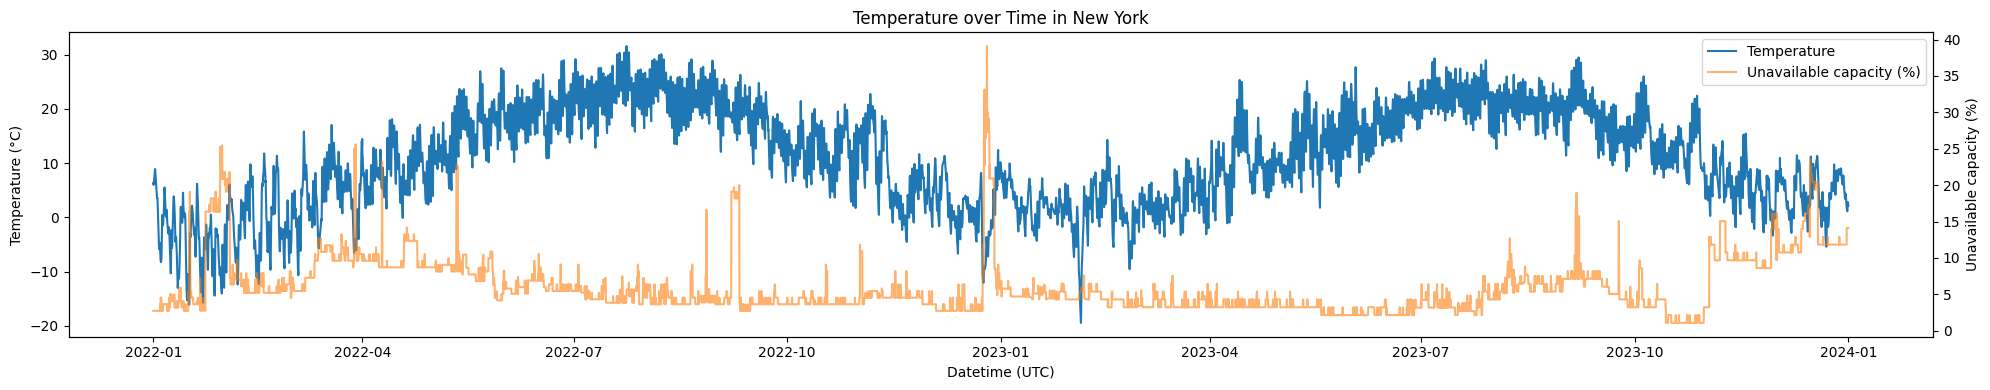

In [30]:
states_to_plot = ['New York'] # 'Massachusetts', 'Pennsylvania'

fig, axs = plt.subplots(len(states_to_plot), 1, figsize=(20,4*len(states_to_plot)))

for i, state in enumerate(states_to_plot):
    inputs_df = scenarios_inputs_by_state[state]
    if len(states_to_plot) == 1:
        ax = axs
    else:
        ax = axs[i]
    dt = inputs_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
    temp = inputs_df['Temperature'].to_numpy()*10

    historical_scenario_df = historical_scenario_by_state[state]
    historical_unavailable_capacity = historical_scenario_df['Unavailable_capacity (%)'].to_numpy()
    historical_dt = historical_scenario_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')

    ax.plot(dt, temp, color='tab:blue', label='Temperature')
    ax2 = ax.twinx()
    ax2.plot(historical_dt, historical_unavailable_capacity, color='tab:orange', label='Unavailable capacity (%)', alpha=0.6)

    ax.set_title(f'Temperature over Time in {state}')
    ax.set_xlabel('Datetime (UTC)')
    ax.set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Unavailable capacity (%)')


    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='best')
plt.tight_layout()

## Scenario generation

In [31]:
states_to_plot = ['New York']

In [36]:
importlib.reload(sg)

generated_scenarios_by_state = {}

for state in states_to_plot:
    generated_scenarios_by_state[state] = {}
    for model_name, model in transition_prob_models.items():
        print(f"Generating scenarios for state: {state}, model: {model_name}")

        covariates_inputs_df = scenarios_inputs_by_state[state]
        generators_data_df = generators_per_state[state]
        generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

        scenarios_per_gen = sg.generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                                generators_data_df,
                                                                                transition_model=model,
                                                                                # transition_prob_models['Frequency_Model'],
                                                                                # models_states[state],
                                                                                num_scenarios=1000,
                                                                                )
        
        generated_scenarios = sg.generate_unavailable_capacity_scenario(scenarios_per_gen, 
                                                            num_scenarios=1000
                                                            )
        generated_scenarios_by_state[state][model_name] = generated_scenarios


Generating scenarios for state: New York, model: CE_Combined


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:07<00:00, 129.84it/s]


Generating scenarios for state: New York, model: FOCAL_Combined


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 144.07it/s]


Generating scenarios for state: New York, model: CE


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 156.34it/s]


Generating scenarios for state: New York, model: FOCAL


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 153.11it/s]


Generating scenarios for state: New York, model: CE_PJM


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 149.54it/s]


Generating scenarios for state: New York, model: FOCAL_PJM


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 150.91it/s]


Generating scenarios for state: New York, model: Frequency_Model


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 149.80it/s]


In [33]:
test_scenario_generation_data_logistic, feat_logist = ppd.preprocess_baseline_logistic_regression_data(test_scenario_generation_data.loc[test_scenario_generation_data['State_NEW YORK'] == 1].copy().reset_index(drop=True), load_stand_params)
test_scenario_generation_data_logistic = test_scenario_generation_data_logistic[['Datetime_UTC']+feat_logist].drop_duplicates()
test_scenario_generation_data_logistic['State_NEW YORK'] = 1
scenarios_inputs_by_state_logistic, generators_per_state_logistic = sg.get_scenario_inputs(test_scenario_generation_data_logistic, test_failures_df)


Getting generators by state: 100%|██████████| 55/55 [01:43<00:00,  1.89s/it]


In [37]:

for state in states_to_plot:
    print(f"Generating scenarios for state: {state}, model: {'Logistic_Regression_Model'}")

    covariates_inputs_df = scenarios_inputs_by_state_logistic[state]#preprocess_baseline_logistic_regression_data(scenarios_inputs_by_state[state], ny_state_params)[0]
    generators_data_df = generators_per_state_logistic[state]
    generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

    scenarios_per_gen = generate_unavailable_capacity_scenario_per_gen_logistic(covariates_inputs_df,
                                                                            generators_data_df,
                                                                            transition_model=logistic_regression_model,
                                                                            # transition_prob_models['Frequency_Model'],
                                                                            # models_states[state],
                                                                            num_scenarios=1000,
                                                                            )
    
    generated_scenarios = sg.generate_unavailable_capacity_scenario(scenarios_per_gen, 
                                                        num_scenarios=1000
                                                        )
    generated_scenarios_by_state[state]['Logistic_Regression_Model'] = generated_scenarios

Generating scenarios for state: New York, model: Logistic_Regression_Model


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:08<00:00, 118.49it/s]


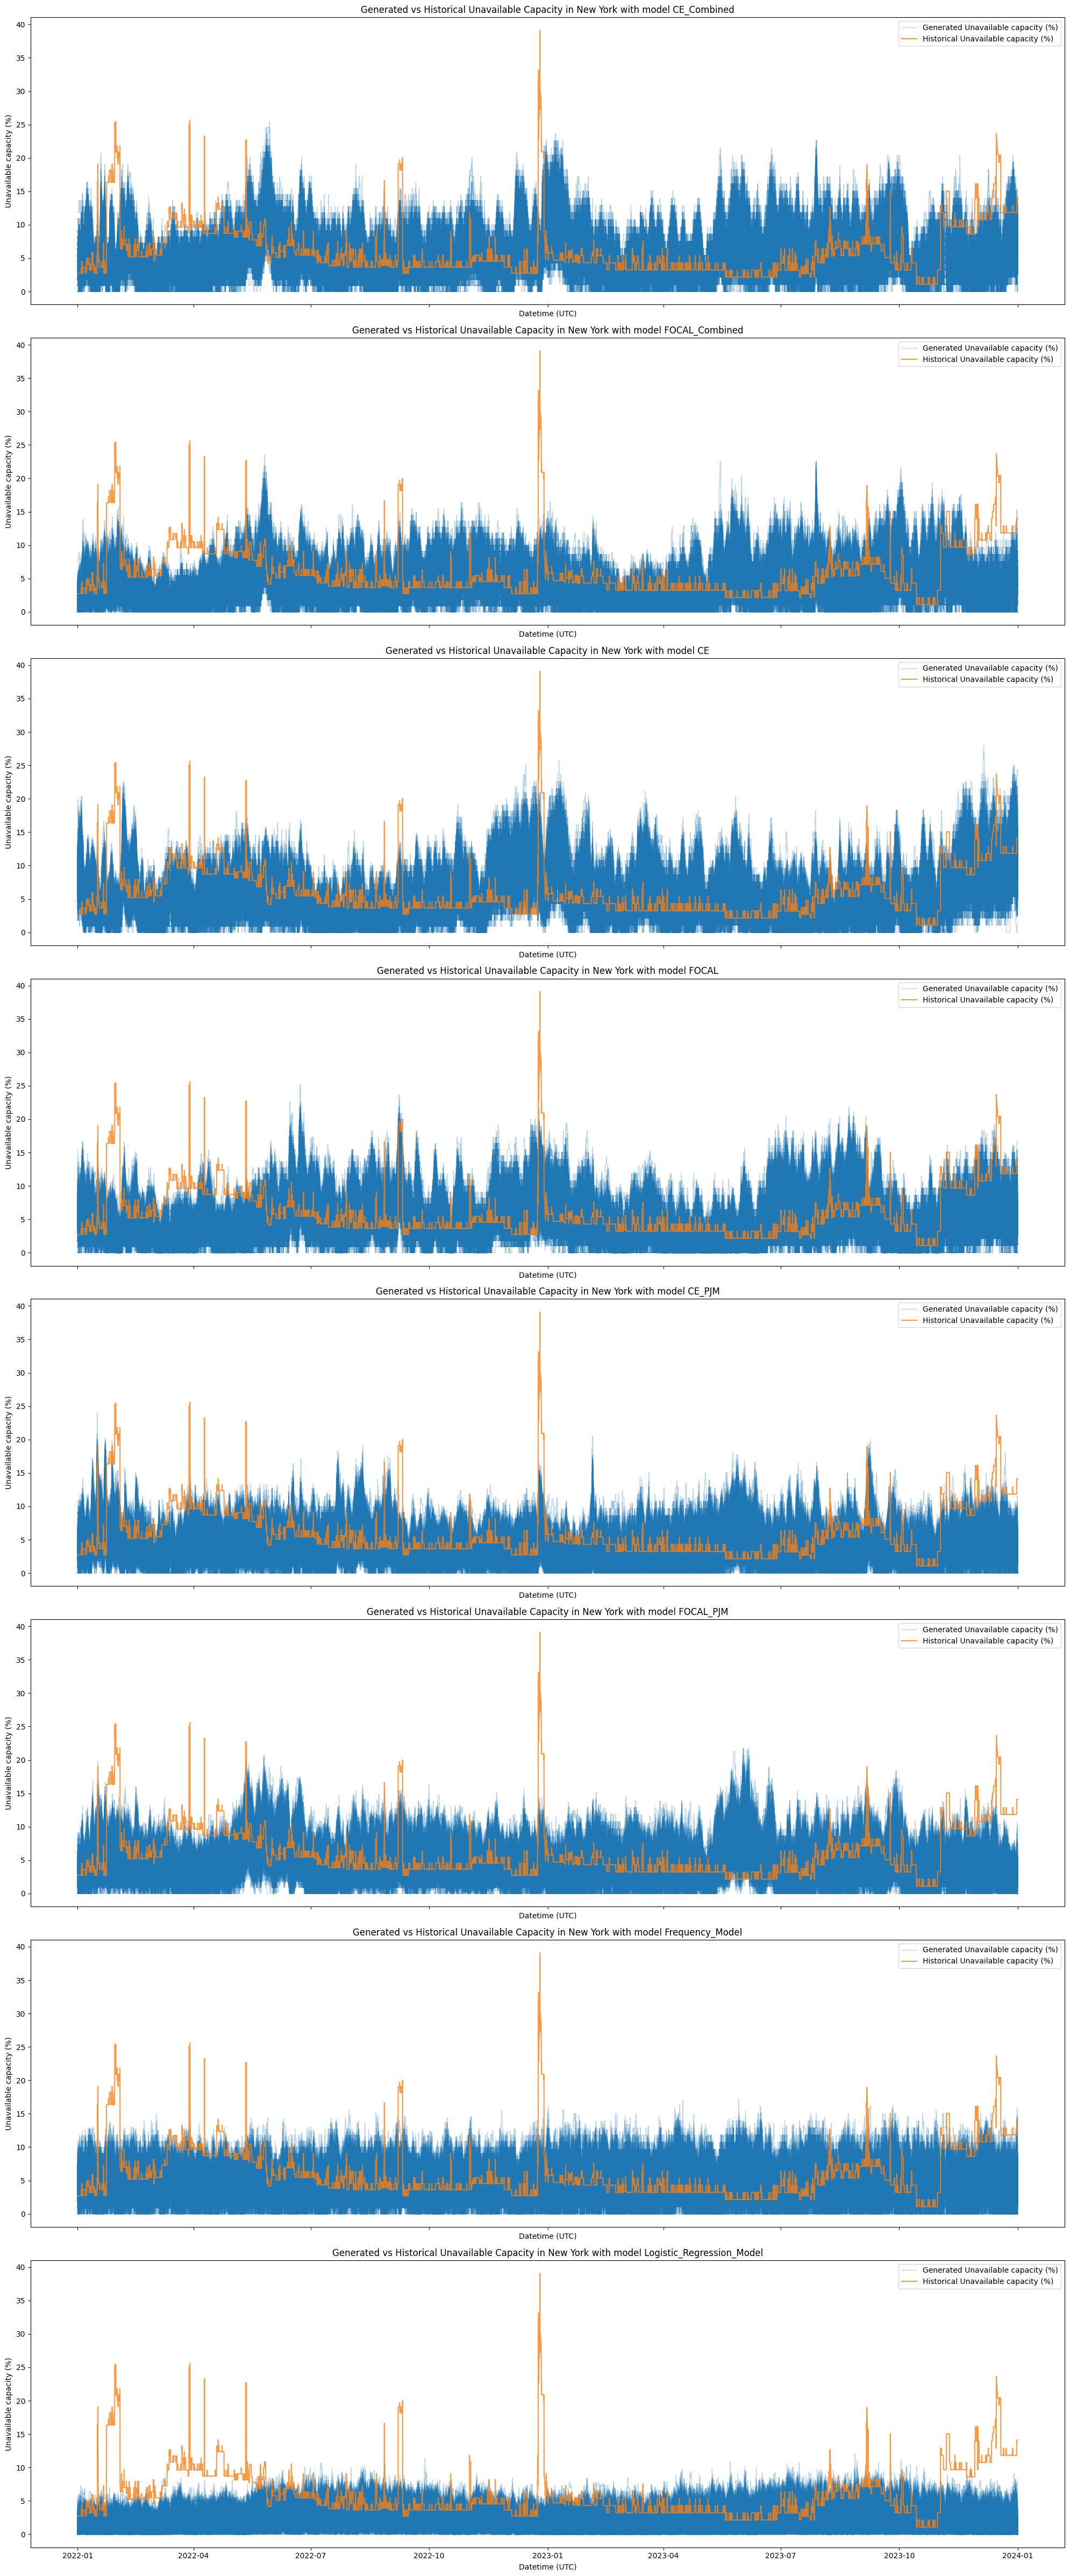

In [38]:
n_plots = sum([1 for v in generated_scenarios_by_state.values() for _ in v])
fig, axs = plt.subplots(n_plots, 1, figsize=(20, 6*n_plots), sharex=True)

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        if n_plots == 1:
            ax = axs
        else:
            ax = axs[i+j]
        for k, sc in enumerate(scenarios):
            dt = sc['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
            unavailable_capacity = sc['Unavailable_capacity (%)'].to_numpy()
            if k == 0:
                ax.plot(dt, unavailable_capacity, color='tab:blue', linewidth=1, alpha=0.3, label='Generated Unavailable capacity (%)')
            else:
                ax.plot(dt, unavailable_capacity, color='tab:blue', linewidth=1, alpha=0.3)


        historical_scenario_df = historical_scenario_by_state[state]
        historical_unavailable_capacity = historical_scenario_df['Unavailable_capacity (%)'].to_numpy()
        historical_dt = historical_scenario_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
        ax.plot(historical_dt, historical_unavailable_capacity, color='tab:orange', label='Historical Unavailable capacity (%)', alpha=0.8)

        ax.set_title(f'Generated vs Historical Unavailable Capacity in {state} with model {model_name}')
        ax.set_xlabel('Datetime (UTC)')
        ax.set_ylabel('Unavailable capacity (%)')
        ax.legend(loc='best')
plt.tight_layout()

## Validation tests : Pointwise validation

### Unconditional marginal

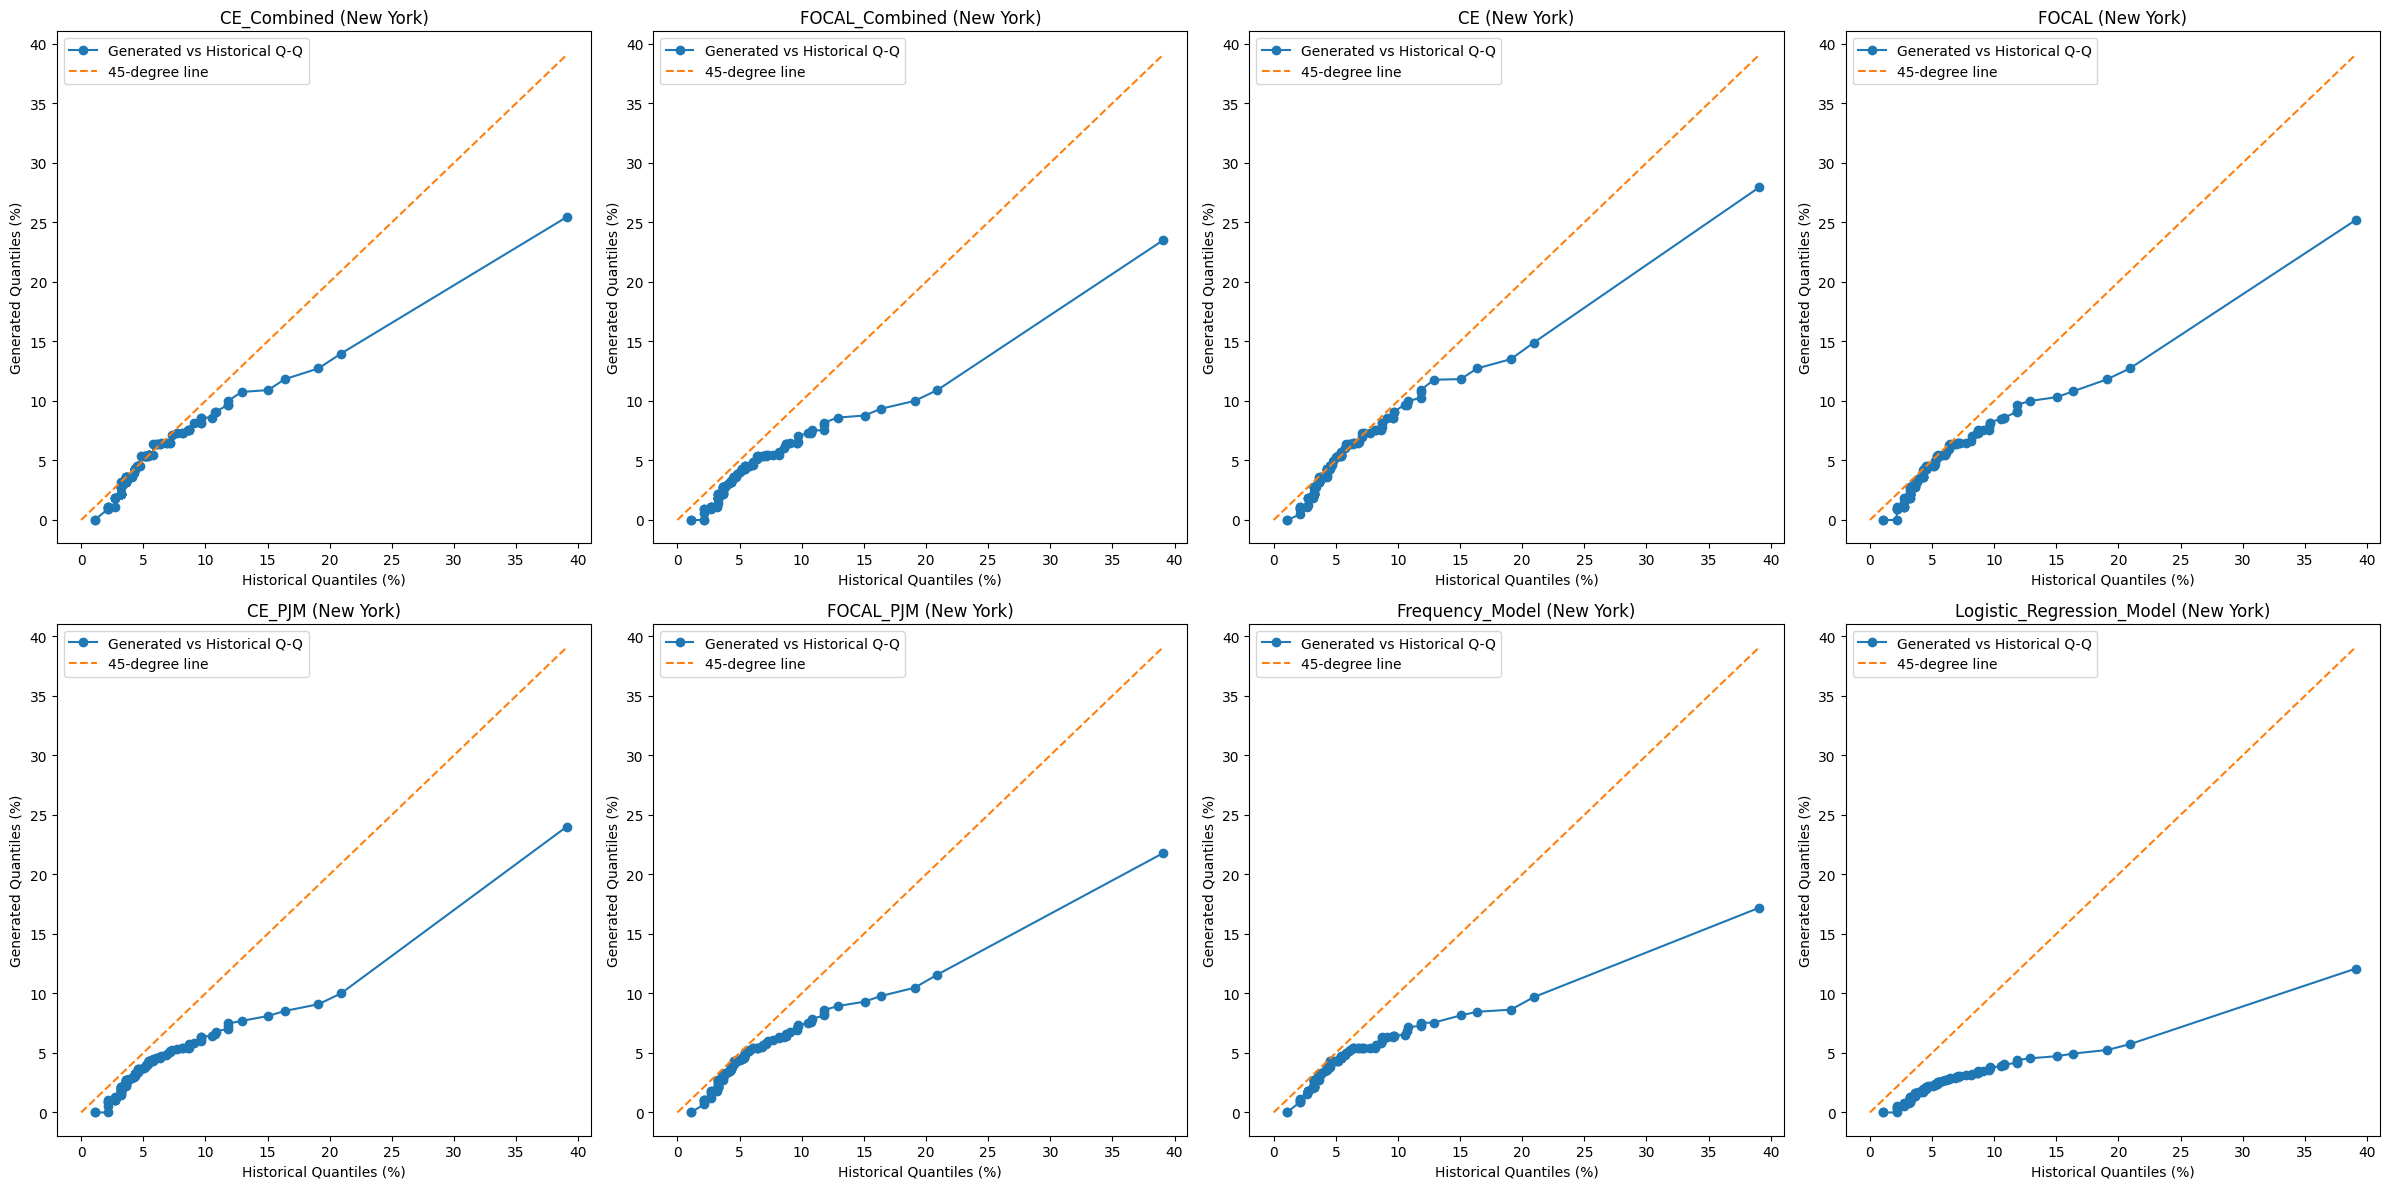

In [48]:
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        historical_scenario = historical_scenario_by_state[state]
        historical_vals = historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten()
        Q_h = np.quantile(historical_vals, np.linspace(0, 1, 101))

        # generated_scenarios = generated_scenarios_by_state[state]
        generated_vals = np.concatenate([scen['Unavailable_capacity (%)'].to_numpy().flatten() for scen in scenarios])
        Q_g = np.quantile(generated_vals, np.linspace(0, 1, 101))
        if n_plots == 1:
            ax = axs
        else:
            r = (i+j) // n_cols
            c = (i+j) % n_cols
            ax = axs[r, c]
        ax.plot(Q_h, Q_g, label='Generated vs Historical Q-Q', marker='o', color='tab:blue')
        ax.plot([0, max([Q_h.max(), Q_g.max()])], [0, max([Q_h.max(), Q_g.max()])], linestyle='--', color='tab:orange', label='45-degree line')
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Historical Quantiles (%)')
        ax.set_ylabel('Generated Quantiles (%)')
        ax.legend(loc='best')
plt.tight_layout()

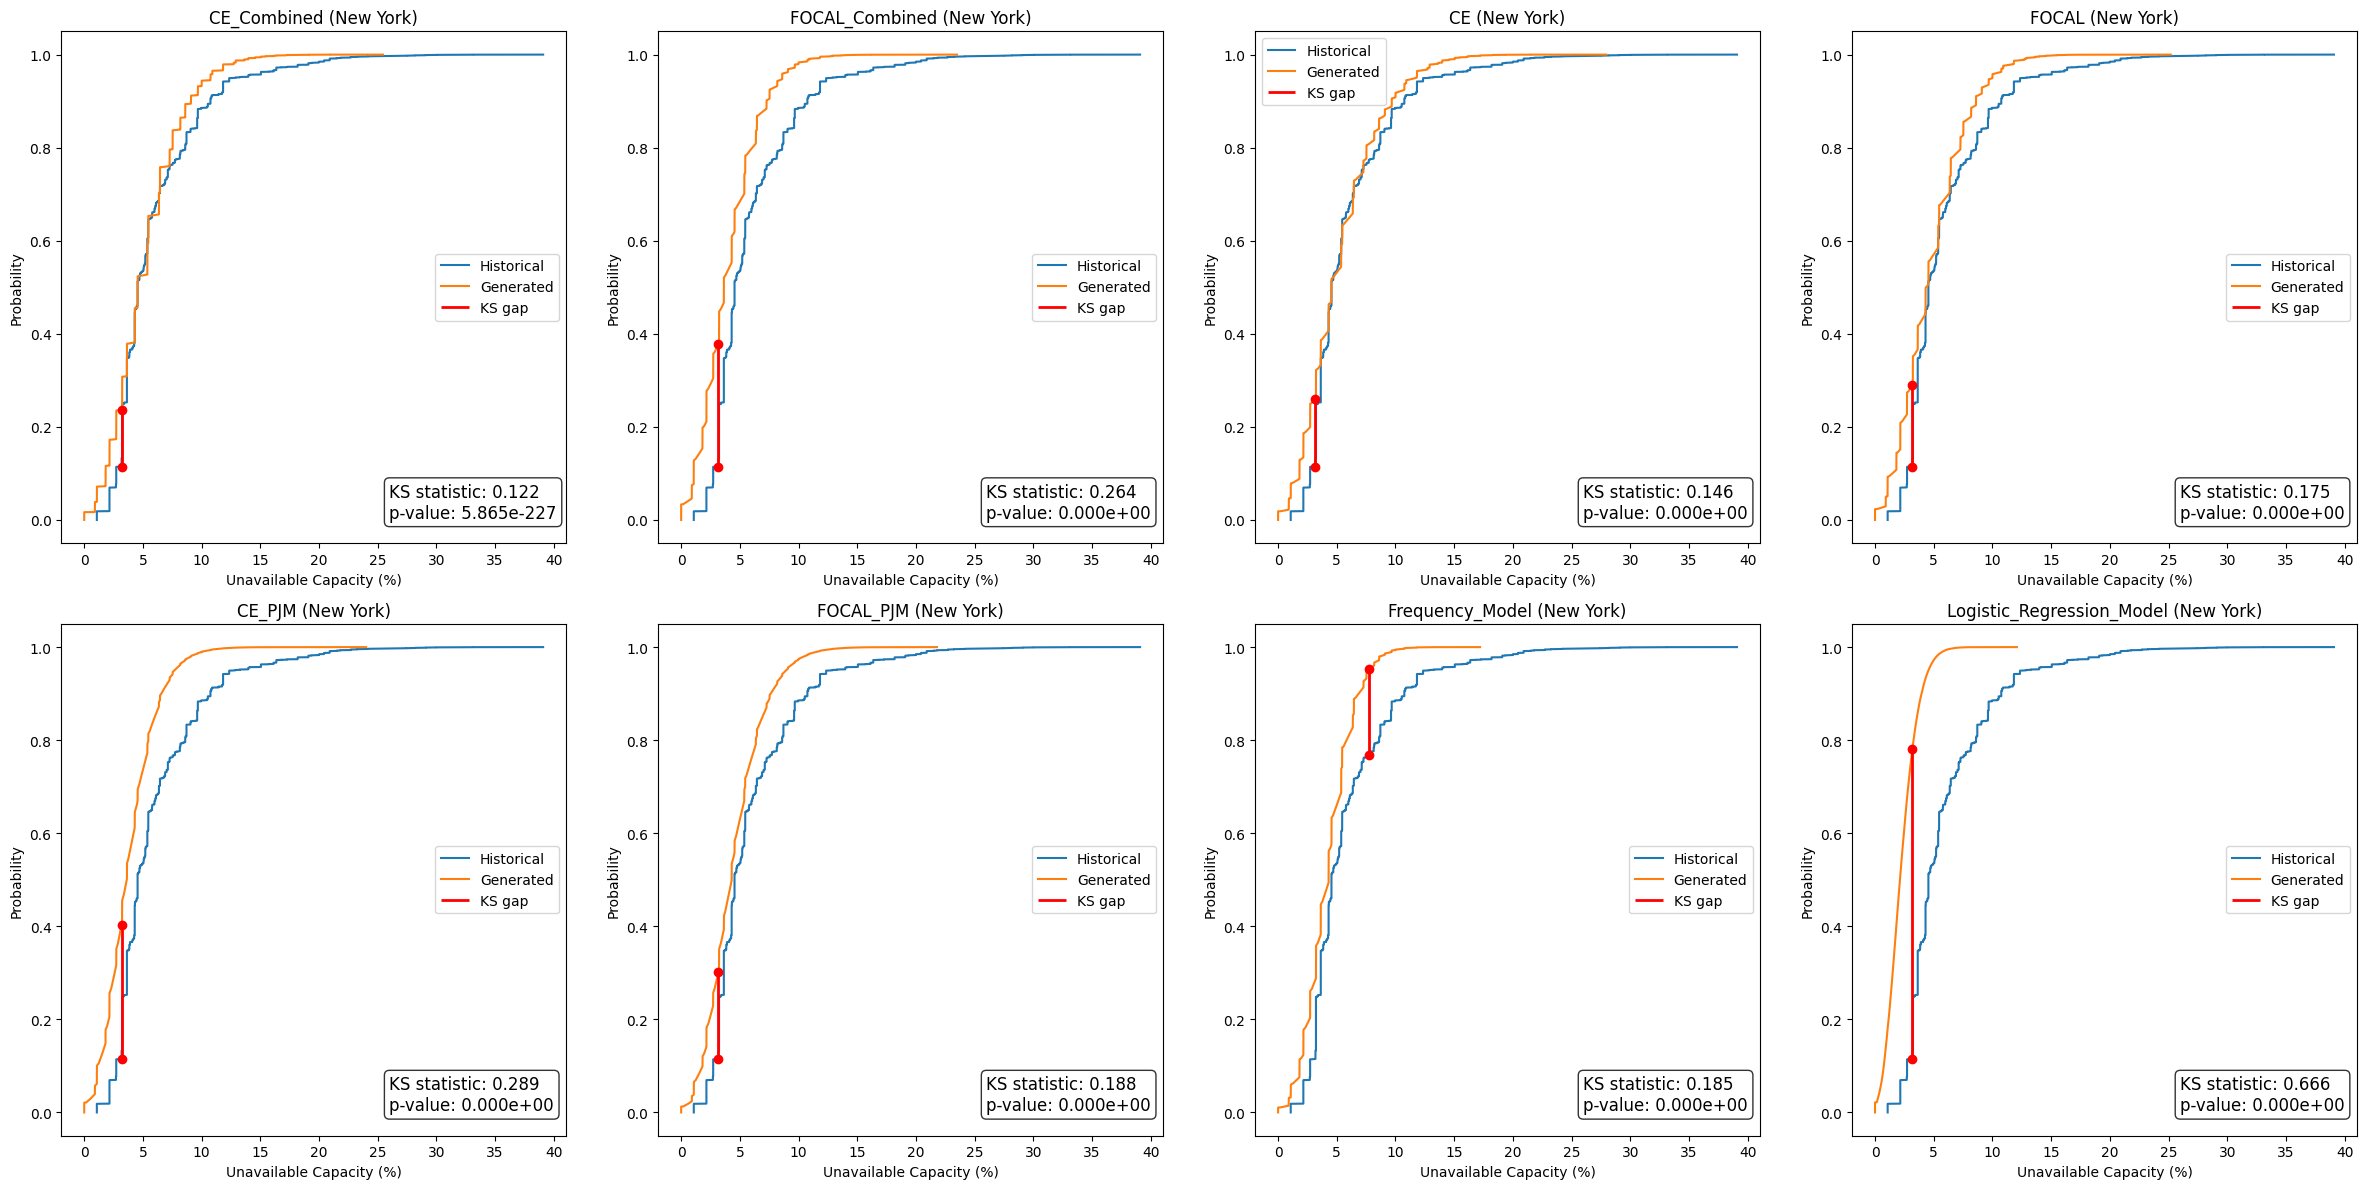

In [49]:
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        historical_scenario = historical_scenario_by_state[state]
        historical_vals = np.sort(historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten())

        generated_scenarios = scenarios#generated_scenarios_by_state[state]
        generated_vals = np.sort(np.concatenate([
            scen['Unavailable_capacity (%)'].to_numpy().flatten() 
            for scen in generated_scenarios
        ]))

        # Compute empirical CDFs
        F_hist = np.linspace(0, 1, len(historical_vals))
        F_gen  = np.linspace(0, 1, len(generated_vals))

        # For KS distance, evaluate both samples on a common grid
        combined = np.sort(np.concatenate([historical_vals, generated_vals]))

        # Empirical CDFs evaluated at combined x
        ecdf_hist = np.searchsorted(historical_vals, combined, side="right") / len(historical_vals)
        ecdf_gen  = np.searchsorted(generated_vals,  combined, side="right") / len(generated_vals)

        # KS statistic and location
        diff = np.abs(ecdf_hist - ecdf_gen)
        ks_stat = diff.max()
        x_ks = combined[np.argmax(diff)]

        # Two-sample KS test
        ks_test = ks_2samp(generated_vals, historical_vals)

        # ---------- Plot ----------
        if n_plots == 1:
            ax = axs
        else:
            r = (i+j) // n_cols
            c = (i+j) % n_cols
            ax = axs[r, c]
        ax.plot(historical_vals, F_hist, label='Historical', color='tab:blue')
        ax.plot(generated_vals, F_gen,  label='Generated', color='tab:orange')

        # Vertical red bar showing KS gap
        ax.vlines(x_ks, 
                ecdf_gen[np.argmax(diff)], 
                ecdf_hist[np.argmax(diff)], 
                color='red', linewidth=2, label='KS gap')

        # Mark the KS location with a dot
        ax.plot([x_ks], [ecdf_gen[np.argmax(diff)]], 'ro')
        ax.plot([x_ks], [ecdf_hist[np.argmax(diff)]], 'ro')

        # Title and axis labels
        # ax.set_title(f'Cumulative Distribution of data in {state} with model {model_name}')
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Unavailable Capacity (%)')
        ax.set_ylabel('Probability')

        # Annotate p-value
        ax.text(0.65, 0.05, 
                f"KS statistic: {ks_stat:.3f}\np-value: {ks_test.pvalue:.3e}",
                transform=ax.transAxes,
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

        ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Conditional marginal

Stratification by temperature

Evaluating model performance for state: New York, model: CE_Combined
Evaluating model performance for state: New York, model: FOCAL_Combined
Evaluating model performance for state: New York, model: CE
Evaluating model performance for state: New York, model: FOCAL
Evaluating model performance for state: New York, model: CE_PJM
Evaluating model performance for state: New York, model: FOCAL_PJM
Evaluating model performance for state: New York, model: Frequency_Model
Evaluating model performance for state: New York, model: Logistic_Regression_Model


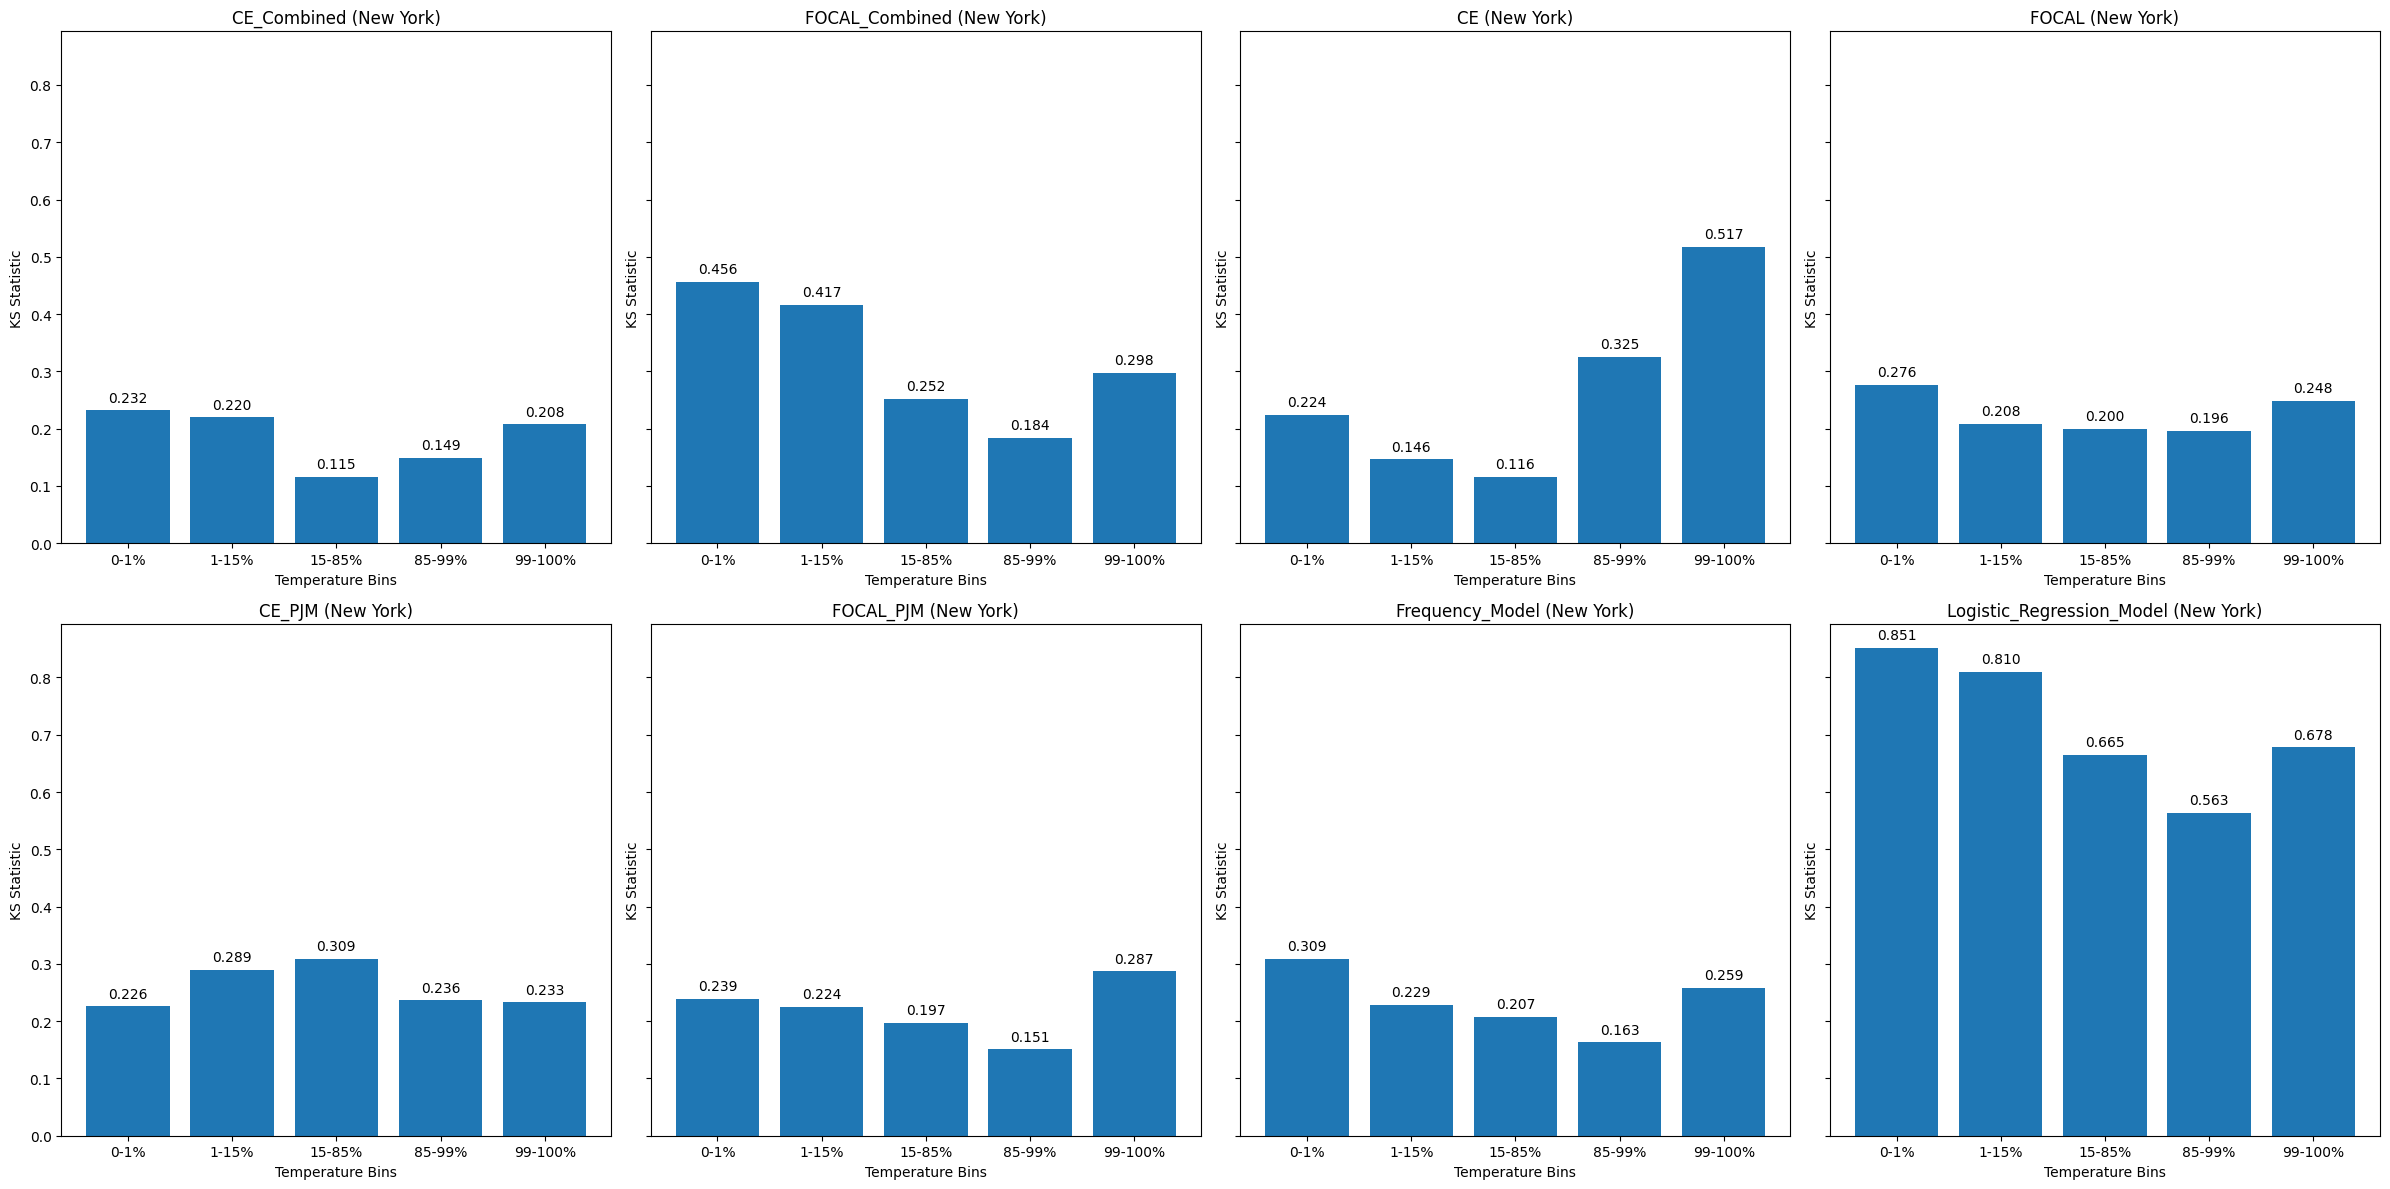

In [53]:
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), sharey=True)

for i, state in enumerate(states_to_plot):
    inp = scenarios_inputs_by_state[state]
    temp = inp['Temperature'].to_numpy()*10
    qs = [0, 0.01, 0.15, 0.85, 0.99, 1.0]
    temp_bins = np.quantile(temp, qs)
    temp_bins[-1] += 0.1  # ensure the max value is included
    temp_indices = np.digitize(temp, temp_bins) - 1  # bins are 0-indexed

    bin_datetimes = {}
    for b in range(len(temp_bins)-1):
        bin_name = f"{int(100*qs[b])}-{int(100*qs[b+1])}%"
        bin_datetimes[bin_name] = inp['Datetime_UTC'].to_numpy()[temp_indices == b]


    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        print(f"Evaluating model performance for state: {state}, model: {model_name}")
        historical_scenario = historical_scenario_by_state[state]
        # historical_vals = historical_scenario['Unavailable_capacity (%)'].to_numpy().flatten()

        model_perfs = {}

        for bin_name, bin_dt in bin_datetimes.items():
            hist_temp_vals = historical_scenario.loc[historical_scenario['Datetime_UTC'].isin(bin_dt), 'Unavailable_capacity (%)'].to_numpy().flatten()
            gen_temp_vals = np.concatenate([scen.loc[scen['Datetime_UTC'].isin(bin_dt), 'Unavailable_capacity (%)'].to_numpy().flatten()
                                            for scen in scenarios])
            
            # Two-sample KS test
            ks_test = ks_2samp(gen_temp_vals, hist_temp_vals)
            model_perfs[bin_name] = {'ks_stat': ks_test.statistic, 'p_value': ks_test.pvalue, 'n_hist': len(hist_temp_vals), 'n_gen': len(gen_temp_vals)}

        model_perfs_df = pd.DataFrame(model_perfs).T
        if n_plots == 1:
            ax = axs
        else:
            r = (i+j) // n_cols
            c = (i+j) % n_cols
            ax = axs[r, c]
        ax.bar(model_perfs_df.index, model_perfs_df['ks_stat'], color='tab:blue')
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Temperature Bins')
        ax.set_ylabel('KS Statistic')
        for k, v in enumerate(model_perfs_df['ks_stat'].values):
            ax.text(k, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
plt.tight_layout()


Quantile coverage

Evaluating model performance for state: New York, model: CE_Combined
Evaluating model performance for state: New York, model: FOCAL_Combined
Evaluating model performance for state: New York, model: CE
Evaluating model performance for state: New York, model: FOCAL
Evaluating model performance for state: New York, model: CE_PJM
Evaluating model performance for state: New York, model: FOCAL_PJM
Evaluating model performance for state: New York, model: Frequency_Model
Evaluating model performance for state: New York, model: Logistic_Regression_Model


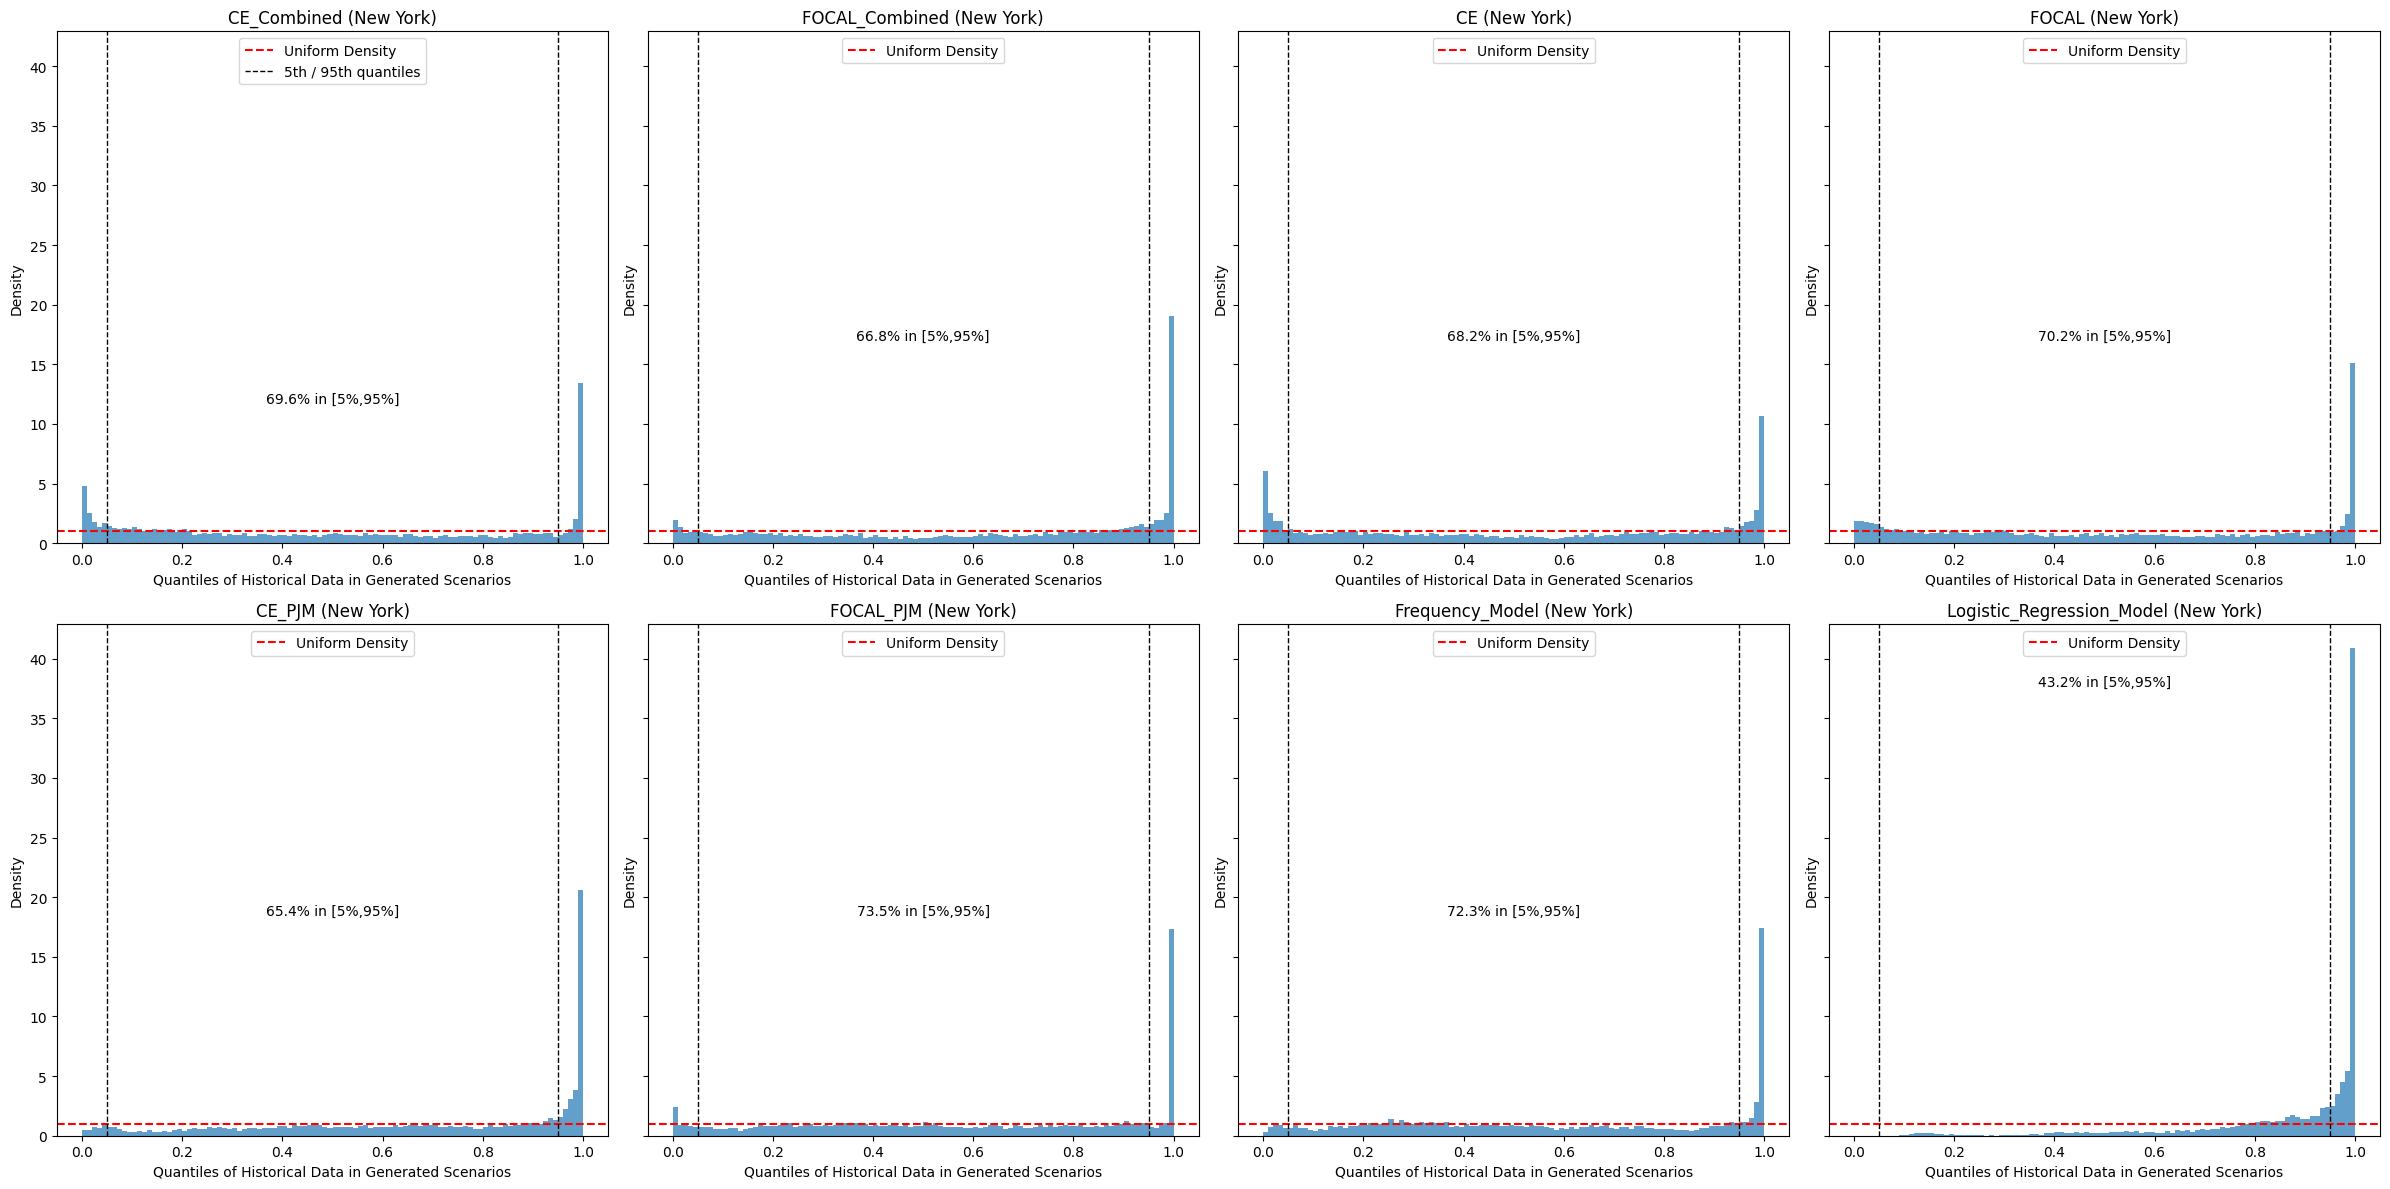

In [51]:
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), sharey=True)

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        print(f"Evaluating model performance for state: {state}, model: {model_name}")

        historical_scenario = historical_scenario_by_state[state]

        # --- 1) Common time axis (assumes all scenarios share same grid) ---
        datetimes = scenarios[0]['Datetime_UTC'].to_numpy()

        # Align historical series on that axis
        hist_series = (
            historical_scenario
            .set_index('Datetime_UTC')
            .reindex(datetimes)['Unavailable_capacity (%)']
        )
        hist = hist_series.to_numpy(dtype=float)   # shape (T,)

        # --- 2) Build scenario matrix gen_matrix: shape (T, S) ---
        gen_matrix = np.stack([
            scen.set_index('Datetime_UTC')
                .reindex(datetimes)['Unavailable_capacity (%)']
                .to_numpy(dtype=float)
            for scen in scenarios
        ], axis=1)  # (T, S)

        # --- 3) Drop any timesteps with NaNs ---
        valid_mask = ~np.isnan(hist) & ~np.any(np.isnan(gen_matrix), axis=1)
        hist_valid = hist[valid_mask]
        gen_valid = gen_matrix[valid_mask, :]     # (T_valid, S)

        if hist_valid.size == 0:
            print(f"No valid timesteps for state={state}, model={model_name}; skipping.")
            continue

        # --- 4) Quantiles of historical in scenario distribution ---
        S = gen_valid.shape[1]
        model_quantiles = (gen_valid < hist_valid[:, None]).sum(axis=1) / S  # (T_valid,)

        # --- 5) Plot histogram ---
        if n_plots == 1:
            ax = axs
        else:
            r = (i+j) // n_cols
            c = (i+j) % n_cols
            ax = axs[r, c]

        ax.hist(
            model_quantiles,
            bins=100,
            range=(0, 1),
            color='tab:blue',
            alpha=0.7,
            density=True
        )
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Quantiles of Historical Data in Generated Scenarios')
        ax.set_ylabel('Density')
        ax.axhline(y=1, color='red', linestyle='--', label='Uniform Density')

        # --- 6) 5th & 95th quantiles + coverage text ---
        # q05 = np.quantile(model_quantiles, 0.05)
        # q95 = np.quantile(model_quantiles, 0.95)
        q05 = 0.05
        q95 = 0.95
        coverage = np.mean((model_quantiles >= q05) & (model_quantiles <= q95))

        # vertical lines
        ax.axvline(q05, color='black', linestyle='--', linewidth=1, label='5th / 95th quantiles' if j == 0 else None)
        ax.axvline(q95, color='black', linestyle='--', linewidth=1)

        # place text roughly near top between the two lines
        ymin, ymax = ax.get_ylim()
        x_mid = 0.5 * (q05 + q95)
        ax.text(
            x_mid,
            ymax * 0.9,
            f"{coverage*100:.1f}% in [5%,95%]",
            ha='center',
            va='top',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
        )

        ax.legend(loc='best')

    break  # remove this if you want to process all states

plt.tight_layout()

## Validation tests : Chronological validation

### Autocorrelation structure

In [43]:
def autocorr(x, lag=1):
    n = len(x)
    x_mean = np.mean(x)
    c0 = np.sum((x - x_mean) ** 2) / n

    def r(h):
        acf = np.sum((x[:n - h] - x_mean) * (x[h:] - x_mean)) / n / c0
        return acf

    return r(lag)

def partial_autocorr(x, lag=1):
    n = len(x)
    x_mean = np.mean(x)

    def r(h):
        if h == 0:
            return 1.0
        elif h == 1:
            return autocorr(x, 1)
        else:
            # pacf_values = [partial_autocorr(x, k) for k in range(1, h)]
            R = np.array([[autocorr(x, abs(i - j)) for j in range(1, h)] for i in range(1, h)])
            r_vector = np.array([autocorr(x, k) for k in range(1, h)])
            phi = np.linalg.solve(R, r_vector)
            return phi[-1]

    return r(lag)

Evaluating model performance for state: New York, model: CE_Combined
Evaluating model performance for state: New York, model: FOCAL_Combined
Evaluating model performance for state: New York, model: CE
Evaluating model performance for state: New York, model: FOCAL
Evaluating model performance for state: New York, model: CE_PJM
Evaluating model performance for state: New York, model: FOCAL_PJM
Evaluating model performance for state: New York, model: Frequency_Model
Evaluating model performance for state: New York, model: Logistic_Regression_Model


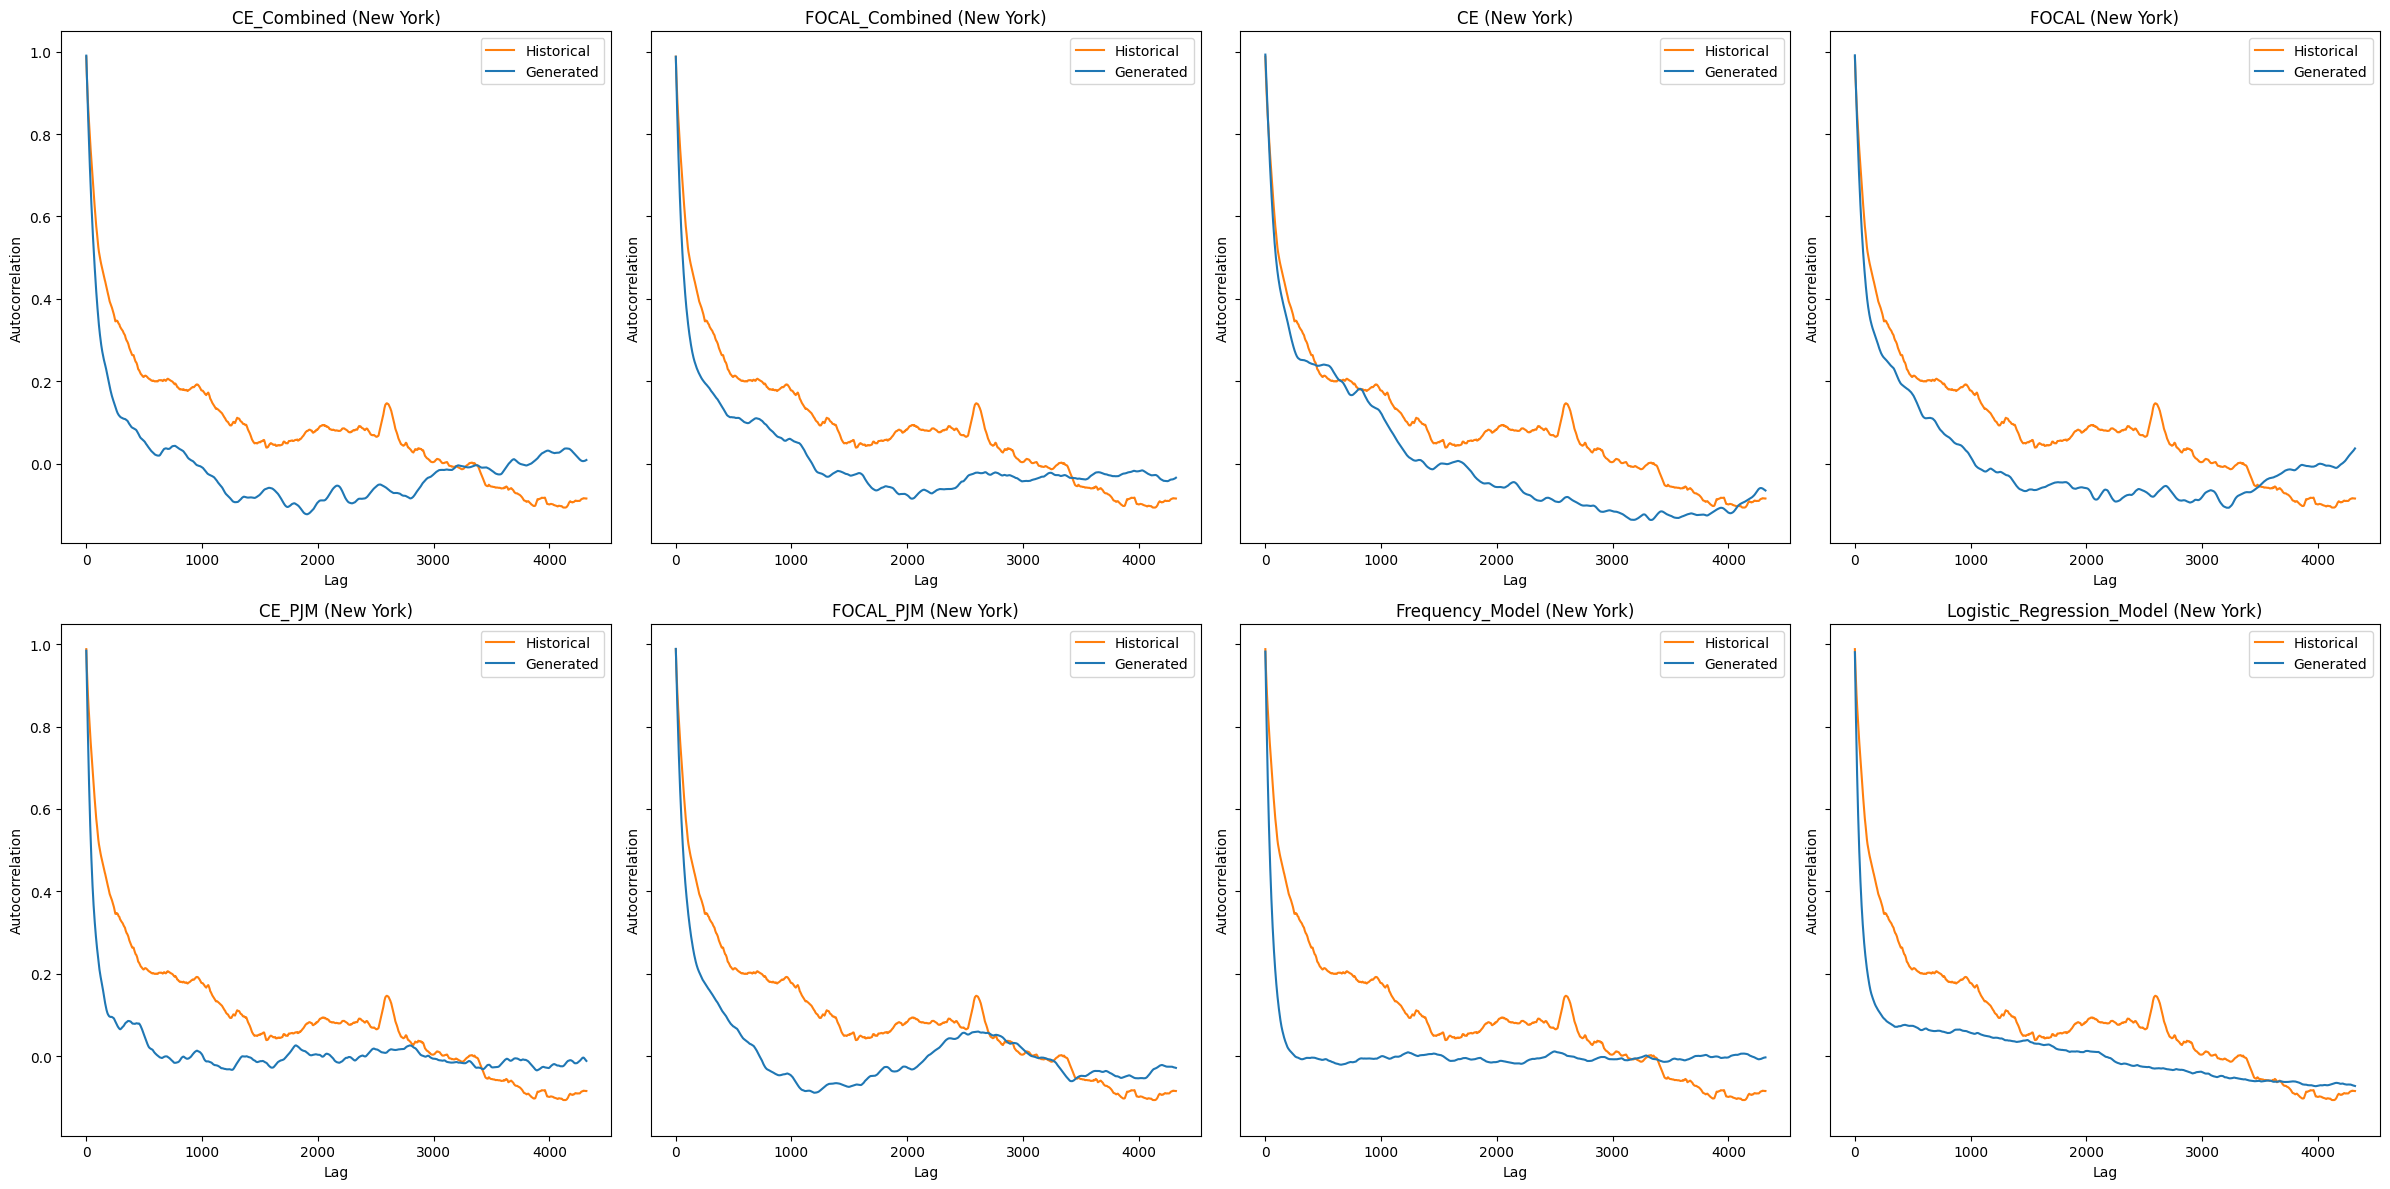

In [52]:
lags = 24*180
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
# n_plots = n_rows * n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), sharey=True)
# fig, axs = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), sharey=True)

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        print(f"Evaluating model performance for state: {state}, model: {model_name}")

        historical_scenario = historical_scenario_by_state[state]['Unavailable_capacity (%)'].to_numpy()

        historical_corr = [autocorr(historical_scenario, lag=k) for k in range(1, lags+1)]
        
        generated_corr = np.array([[autocorr(scen['Unavailable_capacity (%)'].to_numpy(), lag=k) for k in range(1, lags+1)] for scen in scenarios]).mean(axis=0)

        if n_plots == 1:
            ax = axs
        else:
            r = (i+j) // n_cols
            c = (i+j) % n_cols
            ax = axs[r, c]
        ax.plot(range(1, lags+1), historical_corr, label='Historical', color='tab:orange')
        ax.plot(range(1, lags+1), generated_corr, label='Generated', color='tab:blue')
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        ax.legend(loc='best')
plt.tight_layout()



In [ ]:
lags = 24
fig, axs = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), sharey=True)

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        print(f"Evaluating model performance for state: {state}, model: {model_name}")

        historical_scenario = historical_scenario_by_state[state]['Unavailable_capacity (%)'].to_numpy()

        historical_corr = [partial_autocorr(historical_scenario, lag=k) for k in range(1, lags+1)]
        
        generated_corr = np.array([[partial_autocorr(scen['Unavailable_capacity (%)'].to_numpy(), lag=k) for k in range(1, lags+1)] for scen in scenarios]).mean(axis=0)

        if n_plots == 1:
            ax = axs
        else:
            ax = axs[i + j]
        ax.plot(range(1, lags+1), historical_corr, label='Historical', color='tab:orange')
        ax.plot(range(1, lags+1), generated_corr, label='Generated', color='tab:blue')
        ax.set_title(f'{model_name} ({state})')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Partial Autocorrelation')
        ax.legend(loc='best')
plt.tight_layout()



### Persistence of threshold

In [45]:
def duration_above_threshold(ts: np.ndarray, threshold: float) -> list[int]:
    durations = []
    current_duration = 0
    for value in ts:
        if value > threshold:
            current_duration += 1
        else:
            if current_duration > 0:
                durations.append(current_duration)
                current_duration = 0
    if current_duration > 0:
        durations.append(current_duration)
    return durations

Evaluating model performance for state: New York, model: CE_Combined
Evaluating model performance for state: New York, model: FOCAL_Combined
Evaluating model performance for state: New York, model: CE
Evaluating model performance for state: New York, model: FOCAL
Evaluating model performance for state: New York, model: CE_PJM
Evaluating model performance for state: New York, model: FOCAL_PJM
Evaluating model performance for state: New York, model: Frequency_Model


/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


Evaluating model performance for state: New York, model: Logistic_Regression_Model


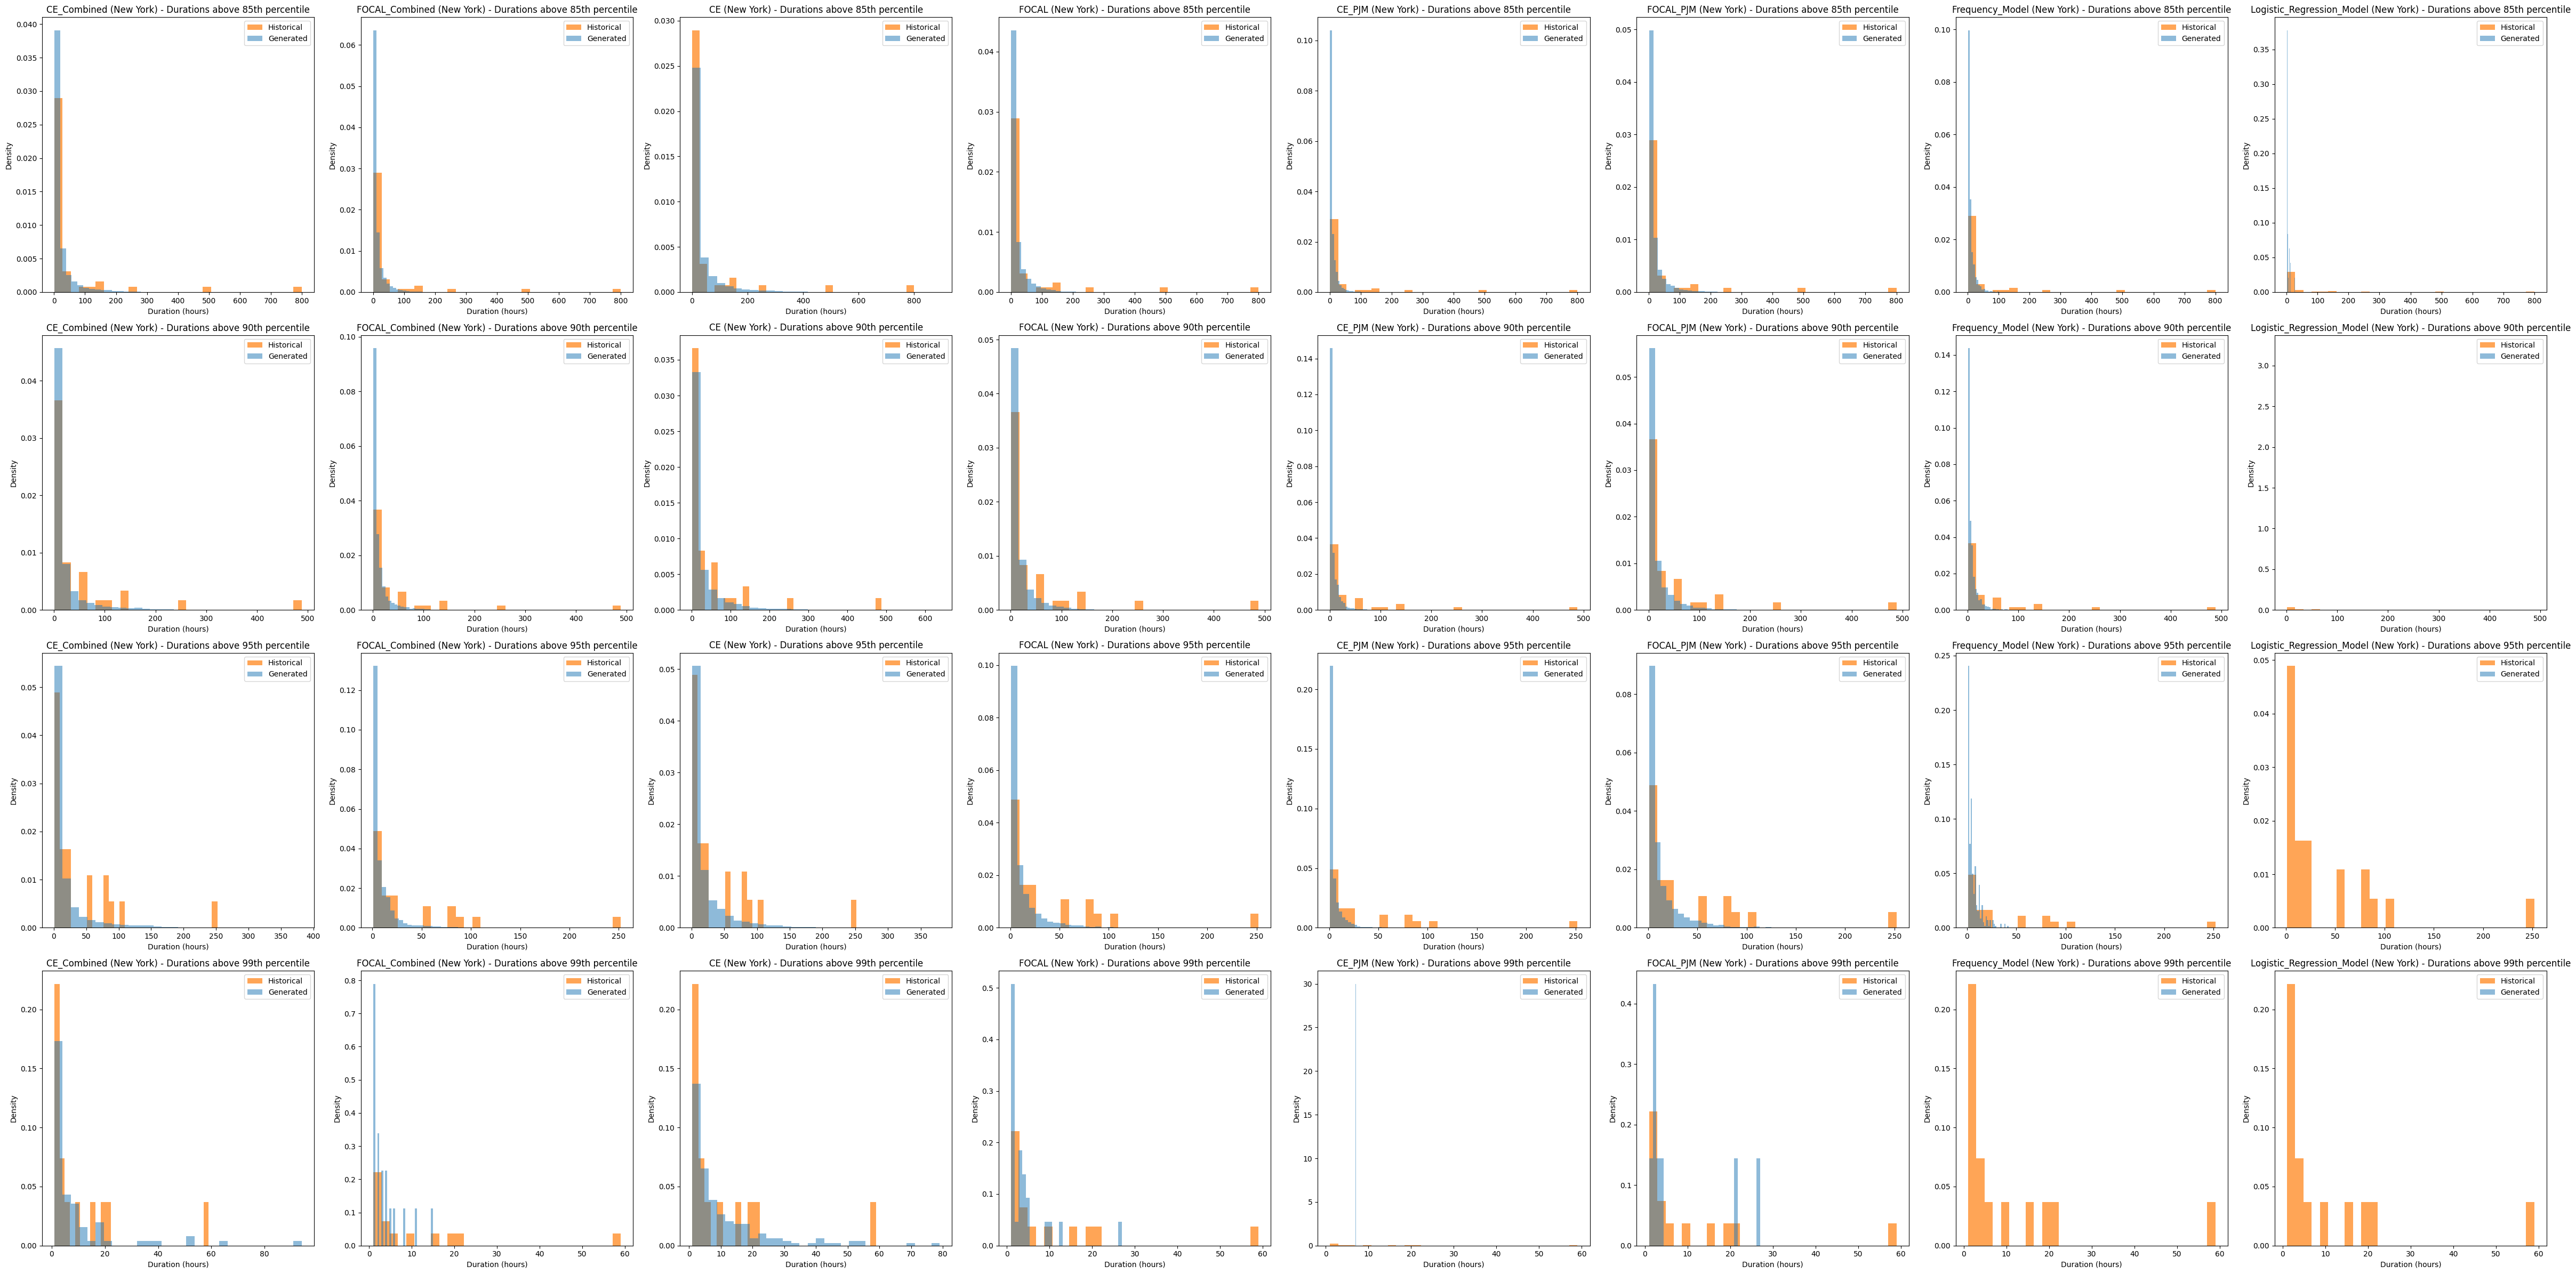

In [ ]:
fig, axs = plt.subplots(4, n_plots, figsize=(6 * n_plots, 6*4))#, sharey=True)

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        print(f"Evaluating model performance for state: {state}, model: {model_name}")

        historical_scenario = historical_scenario_by_state[state]['Unavailable_capacity (%)'].to_numpy()
        
        qs = [0.85, 0.90, 0.95, 0.99]
        gammas = np.quantile(historical_scenario, qs)
        historical_durations = {q: duration_above_threshold(historical_scenario, gamma) for q, gamma in zip(qs, gammas)}
        model_durations = {}
        for q, gamma in zip(qs, gammas):
            all_durations = []
            for scen in scenarios:
                scen_ts = scen['Unavailable_capacity (%)'].to_numpy()
                dur = duration_above_threshold(scen_ts, gamma)
                all_durations.extend(dur)
            model_durations[q] = all_durations
        
        for k, q in enumerate(qs):
            if n_plots == 1:
                ax = axs[k]
            else:
                
                ax = axs[k, i + j]
            # Plot historical duration histogram
            ax.hist(historical_durations[q], bins=30, density=True, alpha=0.7, color='tab:orange', label='Historical')
            # Plot model duration histogram
            ax.hist(model_durations[q], bins=30, density=True, alpha=0.5, color='tab:blue', label='Generated')
            ax.set_title(f'{model_name} ({state}) - Durations above {int(q*100)}th percentile')
            ax.set_xlabel('Duration (hours)')
            ax.set_ylabel('Density')
            ax.legend(loc='best')
plt.tight_layout()